In [1]:
# ========================================
# Steam Reviews — Full Analysis Pipeline
# Saves plots (PNG), tables (CSV/XLSX), and text summaries (TXT)
# ========================================

# --- Optional installs (uncomment if needed) ---
# !pip install vaderSentiment scikit-learn wordcloud

import os, json, warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
from textwrap import wrap

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# ---------- Paths & Figure Style ----------
DATA = Path("all_reviews.csv")  # <-- adjust if needed
OUT_FIG = Path("outputs/figures"); OUT_TAB = Path("outputs/tables"); OUT_TXT = Path("outputs/text")
for p in (OUT_FIG, OUT_TAB, OUT_TXT): p.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (12, 6),
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.grid": True,
    "grid.alpha": 0.25,
})

def savefig(name):
    plt.tight_layout()
    plt.savefig(OUT_FIG / name, bbox_inches="tight")
    plt.close()

def savetab(df_or_series, name_base, colname=None):
    """Save table to CSV and Excel (Series handled too)."""
    if isinstance(df_or_series, pd.Series):
        s = df_or_series
        s.to_csv(OUT_TAB / f"{name_base}.csv")
        s.to_frame(colname or s.name or "value").to_excel(OUT_TAB / f"{name_base}.xlsx")
    else:
        df_or_series.to_csv(OUT_TAB / f"{name_base}.csv", index=True)
        df_or_series.to_excel(OUT_TAB / f"{name_base}.xlsx", index=True)

def savetxt(text, name):
    with open(OUT_TXT / name, "w", encoding="utf-8") as f:
        f.write(text)

def wrap_labels(labels, width=14):
    return ["\n".join(wrap(str(x), width=width)) for x in labels]

In [3]:
# ---------- Load & Clean ----------
df = pd.read_csv(DATA, low_memory=False)
expected_cols = ["recommendation_id", "app_name", "review_text", "voted_up",
                 "author_playtime_at_review_m", "author_playtime_forever_m",
                 "author_playtime_last_two_weeks_m", "monetization_flag"]
missing = [c for c in expected_cols if c not in df.columns]
print("Loaded:", df.shape, "| Missing expected cols:", missing)

df = df.drop_duplicates(subset=["recommendation_id"], ignore_index=True)
df = df[df["review_text"].notna()].copy()

# Clean text (retain case for word clouds)
df["text_clean"] = (df["review_text"].astype(str)
                    .str.replace(r"\s+", " ", regex=True)
                    .str.strip())

# minutes -> hours
for c in ["author_playtime_at_review_m","author_playtime_forever_m","author_playtime_last_two_weeks_m"]:
    if c in df.columns:
        df[c.replace("_m","_h")] = df[c] / 60.0

Loaded: (36000, 24) | Missing expected cols: []


In [4]:
# ---------- Sentiment (VADER) ----------
sid = SentimentIntensityAnalyzer()
df["sentiment"] = df["text_clean"].apply(lambda t: sid.polarity_scores(t)["compound"])

# ---------- Word Clouds (monetization vs non) ----------
try:
    from wordcloud import WordCloud, STOPWORDS
    stopwords = set(STOPWORDS)
    if "monetization_flag" in df.columns:
        text_m = " ".join(df.loc[df["monetization_flag"] == 1, "text_clean"].dropna().tolist())
        if text_m.strip():
            wc_m = WordCloud(width=1400, height=900, background_color="white",
                             stopwords=stopwords, collocations=False).generate(text_m)
            wc_m.to_file(str(OUT_FIG / "monetization_reviews_wordcloud.png"))
        text_nm = " ".join(df.loc[df["monetization_flag"] == 0, "text_clean"].dropna().tolist())
        if text_nm.strip():
            wc_nm = WordCloud(width=1400, height=900, background_color="white",
                              stopwords=stopwords, collocations=False).generate(text_nm)
            wc_nm.to_file(str(OUT_FIG / "non_monetization_reviews_wordcloud.png"))
except Exception as e:
    savetxt(f"Wordcloud generation skipped: {e}", "wordcloud_warning.txt")

In [ ]:
# ---------- EDA ----------
# 1) Review counts by game
if "app_name" in df.columns:
    counts = df["app_name"].value_counts().sort_values(ascending=False)
    ax = counts.plot(kind="bar")
    ax.set_xticklabels(wrap_labels(counts.index), rotation=0)
    ax.set_title("Review count by game"); ax.set_ylabel("Reviews")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y):,}"))
    savefig("eda_reviews_per_game.png")
    savetab(counts, "reviews_per_game", "n_reviews")

# 2) Monetization share by game
if "monetization_flag" in df.columns and "app_name" in df.columns:
    share = df.groupby("app_name")["monetization_flag"].mean().sort_values(ascending=False)
    ax = share.plot(kind="bar")
    ax.set_xticklabels(wrap_labels(share.index), rotation=0)
    ax.set_title("Share of reviews mentioning monetization"); ax.set_ylabel("Proportion")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))
    savefig("monetization_share_by_game.png")
    savetab(share, "monetization_share_by_game", "share_monetization_mentions")

# 3) Playtime histogram (hours at review)
if "author_playtime_at_review_h" in df.columns:
    ax = df["author_playtime_at_review_h"].dropna().plot(kind="hist", bins=60)
    ax.set_title("Distribution of playtime at review (hours)")
    ax.set_xlabel("Hours"); ax.set_ylabel("Frequency")
    savefig("eda_playtime_hist.png")
    savetab(df["author_playtime_at_review_h"].describe(), "playtime_at_review_summary", "stat")

# 4) Sentiment histogram
ax = df["sentiment"].plot(kind="hist", bins=60)
ax.set_title("Distribution of review sentiment (VADER compound)")
ax.set_xlabel("Compound score")
savefig("sentiment_hist.png")
savetab(df["sentiment"].describe(), "sentiment_summary", "stat")

# 5) Avg sentiment by game
if "app_name" in df.columns:
    avg_sent = df.groupby("app_name")["sentiment"].mean().sort_values(ascending=False)
    ax = avg_sent.plot(kind="bar")
    ax.set_xticklabels(wrap_labels(avg_sent.index), rotation=0)
    ax.set_title("Average sentiment by game (VADER compound)")
    ax.set_ylabel("Mean sentiment")
    ax.axhline(0, linestyle="--", linewidth=1)
    savefig("sentiment_avg_by_game.png")
    savetab(avg_sent, "avg_sentiment_by_game", "avg_sentiment")

# Overall summary (for dissertation prose)
summary = {
    "n_reviews": int(len(df)),
    "n_games": int(df["app_name"].nunique()) if "app_name" in df.columns else None,
    "avg_sentiment": float(df["sentiment"].mean()),
    "share_monetization_mentions": float(df["monetization_flag"].mean()) if "monetization_flag" in df.columns else None,
}
savetab(pd.Series(summary), "overall_summary", "value")
savetxt(json.dumps(summary, indent=2), "overall_summary.txt")

# ---------- Topic Modelling (TF-IDF + LDA) ----------
texts = df["text_clean"].dropna().astype(str).tolist()
MAX_DOCS = 60000
if len(texts) > MAX_DOCS:
    texts = texts[:MAX_DOCS]

tfidf = TfidfVectorizer(min_df=5, max_df=0.85, ngram_range=(1,2), max_features=100000)
X = tfidf.fit_transform(texts)

n_topics = 6
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method="batch")
W = lda.fit_transform(X)   # doc-topic
H = lda.components_        # topic-term

terms = np.array(tfidf.get_feature_names_out())
topn = 12
topic_terms = {f"Topic_{i+1}": terms[np.argsort(H[i])[::-1][:topn]].tolist() for i in range(n_topics)}
pd.DataFrame(topic_terms).to_csv(OUT_TAB / "lda_top_terms.csv", index=False)
pd.DataFrame(topic_terms).to_excel(OUT_TAB / "lda_top_terms.xlsx", index=False)
savetxt(json.dumps(topic_terms, indent=2), "lda_top_terms.txt")

for i in range(n_topics):
    idx = np.argsort(H[i])[::-1][:topn]
    words = terms[idx]; weights = H[i, idx]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(words))[::-1], weights[::-1])
    ax.set_yticks(range(len(words))[::-1]); ax.set_yticklabels(words[::-1])
    ax.set_title(f"LDA Topic {i+1} — Top terms")
    ax.set_xlabel("Term weight")
    savefig(f"lda_topic_{i+1}_top_terms.png")

In [5]:
# ---------- Clustering (K-Means) ----------
features = [c for c in ["author_playtime_at_review_h","sentiment","monetization_flag"] if c in df.columns]
if len(features) >= 2:
    clust_df = df.dropna(subset=features).copy()
    scaler = StandardScaler()
    Xc = scaler.fit_transform(clust_df[features].values)

    # Track per-k silhouettes
    k_scores = []
    best_k, best_score, best_labels, best_km = None, -1, None, None
    for k in [3,4,5]:
        km = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = km.fit_predict(Xc)
        score = silhouette_score(Xc, labels)
        k_scores.append({"k": k, "silhouette": score})
        if score > best_score:
            best_k, best_score, best_labels, best_km = k, score, labels, km

    clust_df["cluster"] = best_labels
    profile = clust_df.groupby("cluster")[features].mean()
    savetab(profile, "cluster_profiles", None)
    savetab(pd.DataFrame(k_scores).set_index("k"), "clustering_silhouette_by_k", "silhouette")
    savetxt(f"Best k: {best_k}\nSilhouette: {best_score:.3f}\nFeatures: {features}", "cluster_summary.txt")

    if set(["author_playtime_at_review_h","sentiment"]).issubset(clust_df.columns):
        fig, ax = plt.subplots()
        sc = ax.scatter(clust_df["author_playtime_at_review_h"], clust_df["sentiment"],
                        c=clust_df["cluster"], s=12, alpha=0.5)
        ax.set_xlabel("Playtime at review (hours)"); ax.set_ylabel("Sentiment (compound)")
        ax.set_title(f"K-Means clusters (k={best_k}) — Sentiment vs Playtime")
        savefig("clusters_scatter_sentiment_playtime.png")

  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [6]:
# ---------- Predictive Modelling ----------
# Target: 1 = negative review; prefer voted_up if available, else sentiment<0 fallback
if "voted_up" in df.columns:
    y = (~df["voted_up"].astype(bool)).astype(int)
else:
    y = (df["sentiment"] < 0).astype(int)

model_feats = [c for c in ["author_playtime_at_review_h","votes_up","monetization_flag","sentiment"] if c in df.columns]
if len(model_feats) >= 2:
    mod_df = df.dropna(subset=model_feats).copy()
    X_train, X_test, y_train, y_test = train_test_split(mod_df[model_feats], y.loc[mod_df.index],
                                                        test_size=0.2, random_state=42, stratify=y.loc[mod_df.index])

    # ----- Logistic Regression -----
    lr = LogisticRegression(max_iter=2000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    report_lr = classification_report(y_test, y_pred_lr, digits=3)
    savetxt("Logistic Regression\n" + report_lr, "clf_lr_report.txt")

    # LR Confusion Matrix
    try:
        fig, ax = plt.subplots()
        ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, ax=ax)
        ax.set_title("Logistic Regression — Confusion Matrix")
        savefig("clf_lr_confusion_matrix.png")
    except Exception as e:
        savetxt(f"LR confusion matrix skipped: {e}", "clf_lr_confusion_warning.txt")

    # LR ROC
    try:
        fig, ax = plt.subplots()
        RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax)
        ax.set_title("Logistic Regression — ROC Curve")
        savefig("clf_lr_roc.png")
    except Exception as e:
        savetxt(f"LR ROC skipped: {e}", "clf_lr_roc_warning.txt")

    # ----- Random Forest -----
    rf = RandomForestClassifier(n_estimators=400, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    report_rf = classification_report(y_test, y_pred_rf, digits=3)
    savetxt("Random Forest\n" + report_rf, "clf_rf_report.txt")

    # RF Confusion Matrix
    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=ax)
    ax.set_title("Random Forest — Confusion Matrix")
    savefig("clf_rf_confusion_matrix.png")

    # RF ROC
    try:
        fig, ax = plt.subplots()
        RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax)
        ax.set_title("Random Forest — ROC Curve")
        savefig("clf_rf_roc.png")
    except Exception as e:
        savetxt(f"ROC generation skipped: {e}", "clf_rf_roc_warning.txt")

    # RF Feature Importance
    try:
        importances = pd.Series(rf.feature_importances_, index=model_feats).sort_values(ascending=True)
        ax = importances.plot(kind="barh")
        ax.set_title("Random Forest — Feature Importances")
        ax.set_xlabel("Importance")
        savefig("clf_rf_feature_importances.png")
        savetab(importances.sort_values(ascending=False), "clf_rf_feature_importances", "importance")
    except Exception as e:
        savetxt(f"Feature importance skipped: {e}", "clf_rf_importance_warning.txt")

    # ----- Random Forest Cross-Validation -----
    try:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        rf_cv_acc = cross_val_score(rf, mod_df[model_feats], y.loc[mod_df.index], cv=skf, scoring="accuracy")
        rf_cv_f1  = cross_val_score(rf, mod_df[model_feats], y.loc[mod_df.index], cv=skf, scoring="f1")
        rf_cv_auc = cross_val_score(rf, mod_df[model_feats], y.loc[mod_df.index], cv=skf, scoring="roc_auc")

        cv_df = pd.DataFrame({
            "fold": range(1, len(rf_cv_acc) + 1),
            "accuracy": rf_cv_acc,
            "f1": rf_cv_f1,
            "roc_auc": rf_cv_auc
        })
        savetab(cv_df, "rf_cross_validation_scores")
        rf_cv_summary = {
            "accuracy_mean": float(rf_cv_acc.mean()), "accuracy_std": float(rf_cv_acc.std()),
            "f1_mean": float(rf_cv_f1.mean()), "f1_std": float(rf_cv_f1.std()),
            "roc_auc_mean": float(rf_cv_auc.mean()), "roc_auc_std": float(rf_cv_auc.std())
        }
        savetxt("Random Forest CV (5-fold)\n" + json.dumps(rf_cv_summary, indent=2),
                "rf_cross_validation_summary.txt")
    except Exception as e:
        savetxt(f"RF cross-validation skipped: {e}", "rf_cross_validation_warning.txt")

app_name  count
0               Dota 2   3998
1         Apex Legends   3990
2     Counter-Strike 2   3987
3  PUBG: BATTLEGROUNDS   3987
4      Team Fortress 2   3985
5             Lost Ark   3985
6        Path of Exile   3982
7             Warframe   3981
8            Destiny 2   3979

app_name  monetization_flag
0             Lost Ark           0.088833
1             Warframe           0.045968
2            Destiny 2           0.035436
3         Apex Legends           0.031830
4        Path of Exile           0.028629
5  PUBG: BATTLEGROUNDS           0.024831
6     Counter-Strike 2           0.015801
7      Team Fortress 2           0.013049
8               Dota 2           0.000500

Unnamed: 0  author_playtime_at_review_h
0      count                 35874.000000
1       mean                   624.420574
2        std                  1331.062308
3        min                     0.083333
4        25%                    24.750000
5        50%                   158.366667
6        75%                   701.383333
7        max                 31201.700000

Unnamed: 0     sentiment
0      count  35874.000000
1       mean      0.252820
2        std      0.481074
3        min     -0.999400
4        25%      0.000000
5        50%      0.400300
6        75%      0.636900
7        max      0.999800

app_name  sentiment
0               Dota 2   0.593851
1             Warframe   0.359856
2        Path of Exile   0.292074
3      Team Fortress 2   0.273748
4             Lost Ark   0.231342
5            Destiny 2   0.162810
6  PUBG: BATTLEGROUNDS   0.138849
7     Counter-Strike 2   0.126690
8         Apex Legends   0.095371

Unnamed: 0             0
0                    n_reviews  35874.000000
1                      n_games      9.000000
2                avg_sentiment      0.252820
3  share_monetization_mentions      0.031639

cluster  author_playtime_at_review_h  sentiment  monetization_flag
0        0                  3447.342635   0.191849           0.000000
1        1                   310.981912  -0.211709           0.000000
2        2                   337.800282   0.605252           0.000000
3        3                  8856.101079   0.225223           0.037946
4        4                   827.530426   0.335822           1.000000

k  silhouette
0  3    0.488486
1  4    0.555232
2  5    0.566003

Unnamed: 0         0
0  author_playtime_at_review_h  0.405169
1                    sentiment  0.345769
2                     votes_up  0.241362
3            monetization_flag  0.007700

Unnamed: 0  fold  accuracy        f1   roc_auc
0           0     1  0.811568  0.605371  0.840301
1           1     2  0.817700  0.613018  0.838107
2           2     3  0.829826  0.631896  0.856769
3           3     4  0.823275  0.618072  0.845418
4           4     5  0.826178  0.623377  0.852170

Topic_1    Topic_2   Topic_3     Topic_4   Topic_5 Topic_6
0        good  best game        gg          10       fun     the
1        nice       best      like        cool      game      to
2        game   the best   awesome         ass  fun game     and
3       great       game  cheaters       10 10      shit      it
4  great game        the      game     alright        it     you
5        very  good game      dont       sucks  very fun      of
6   very good       good   like it        game      very    game
7          ok         no    goated         mid      play      is
8         its       peak      this        fuck       its     yes
9   nice game  game ever        it  game sucks        is    this

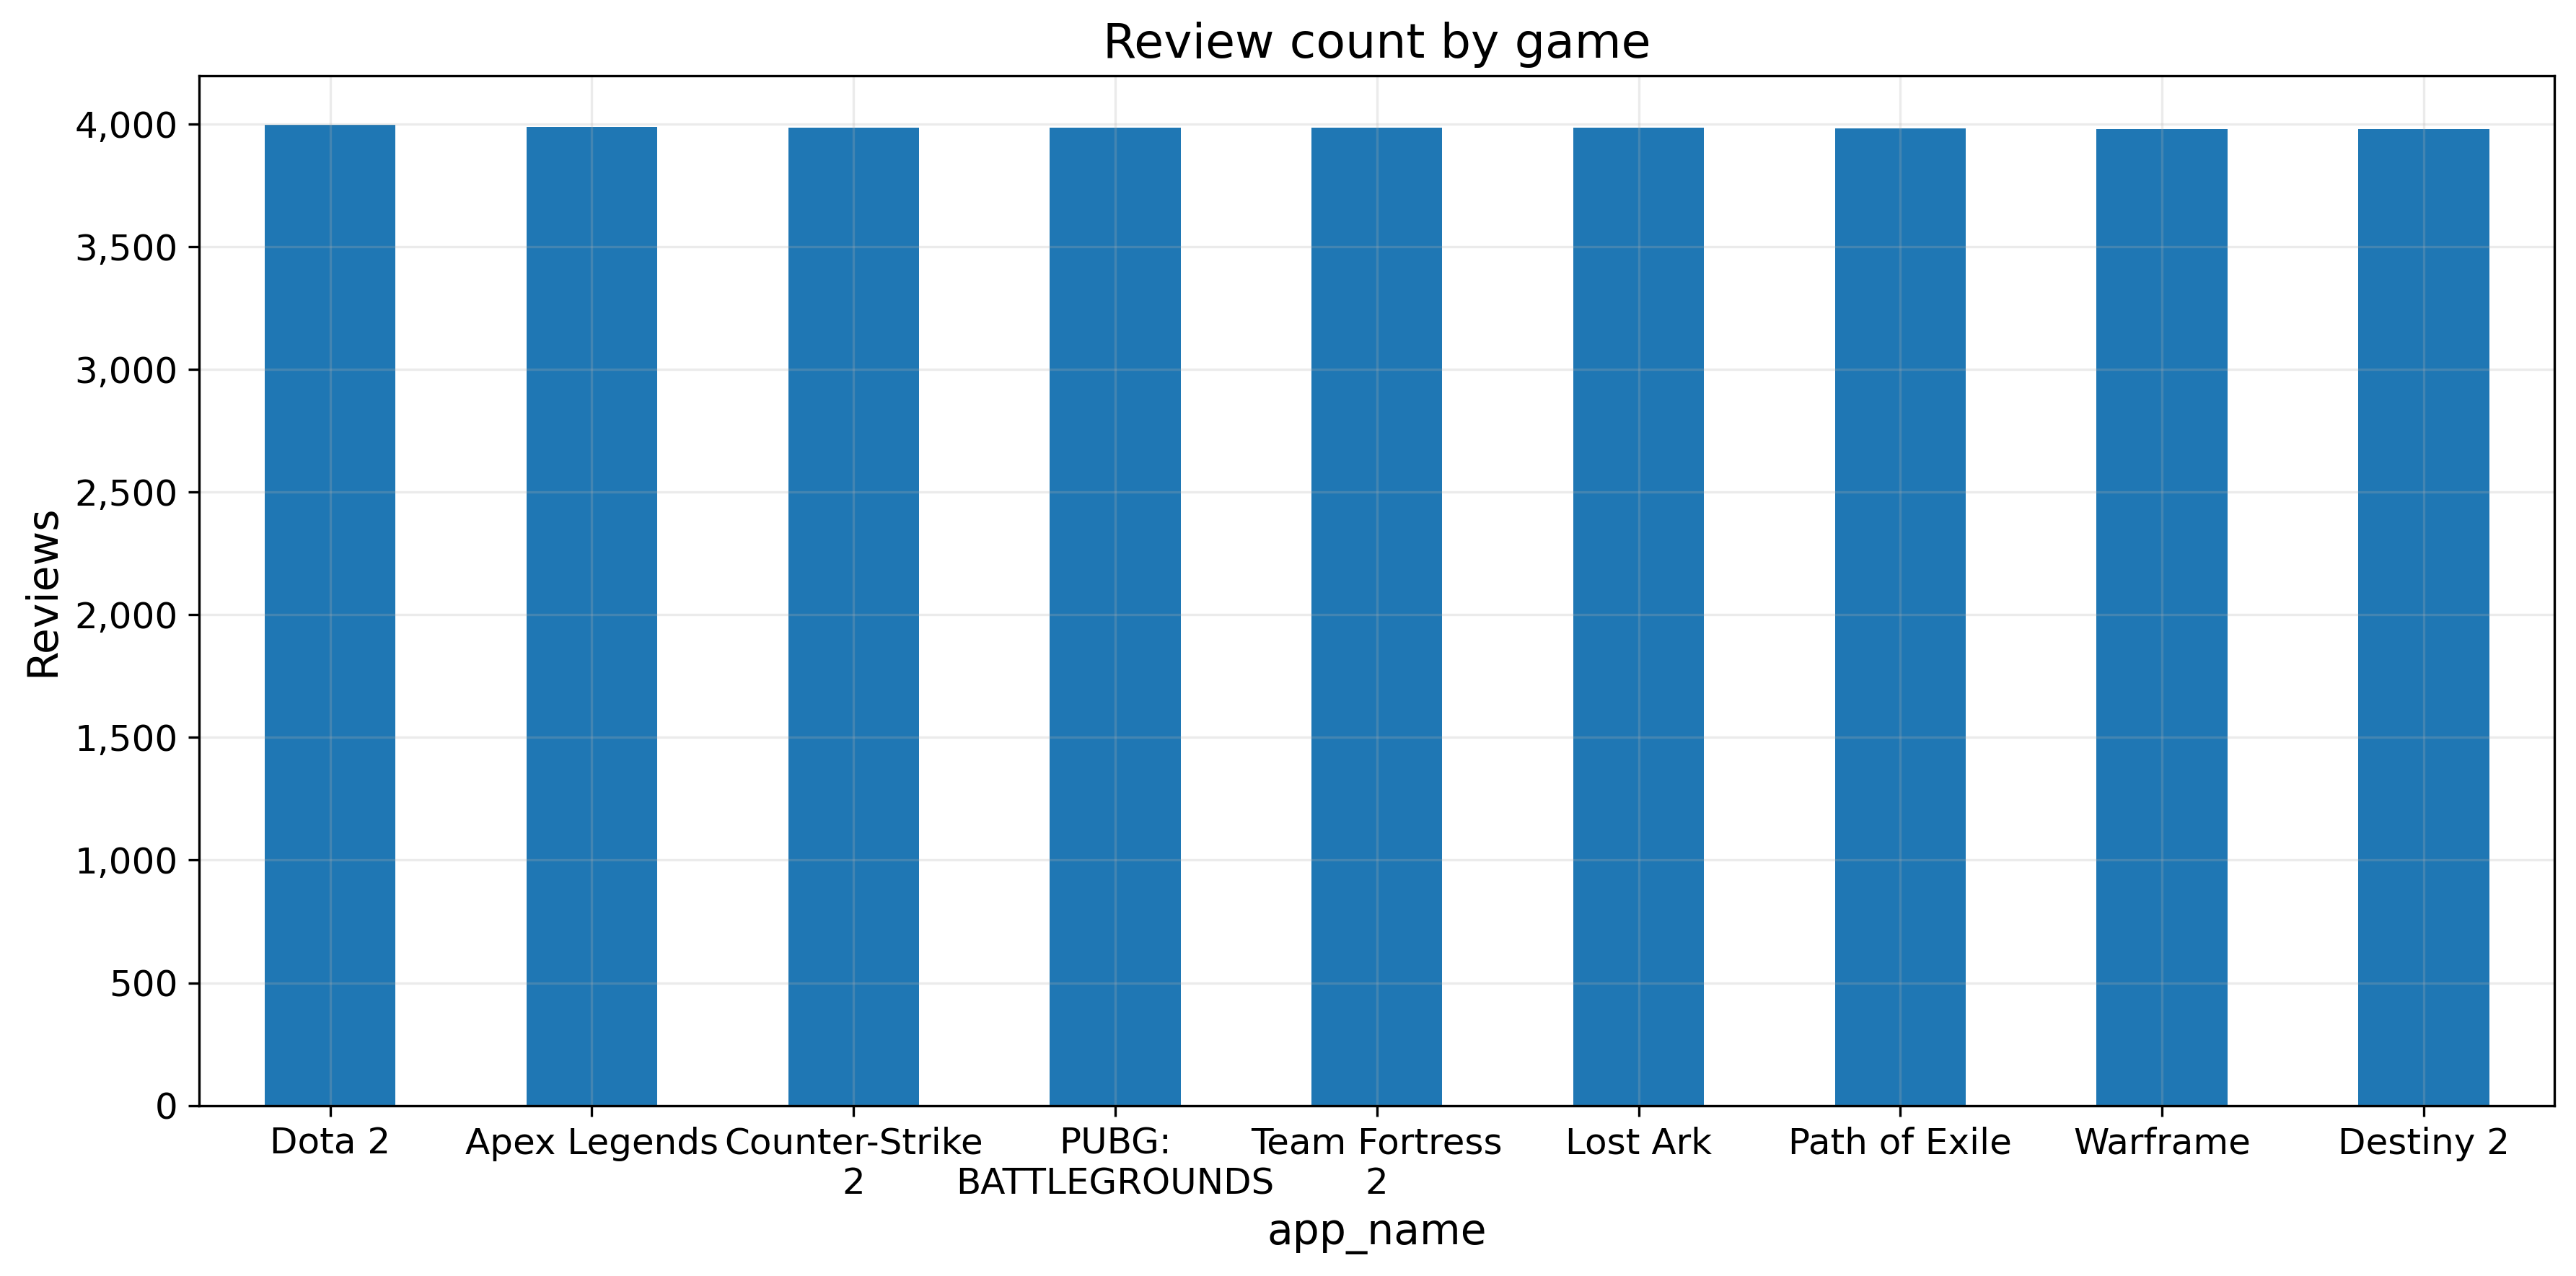

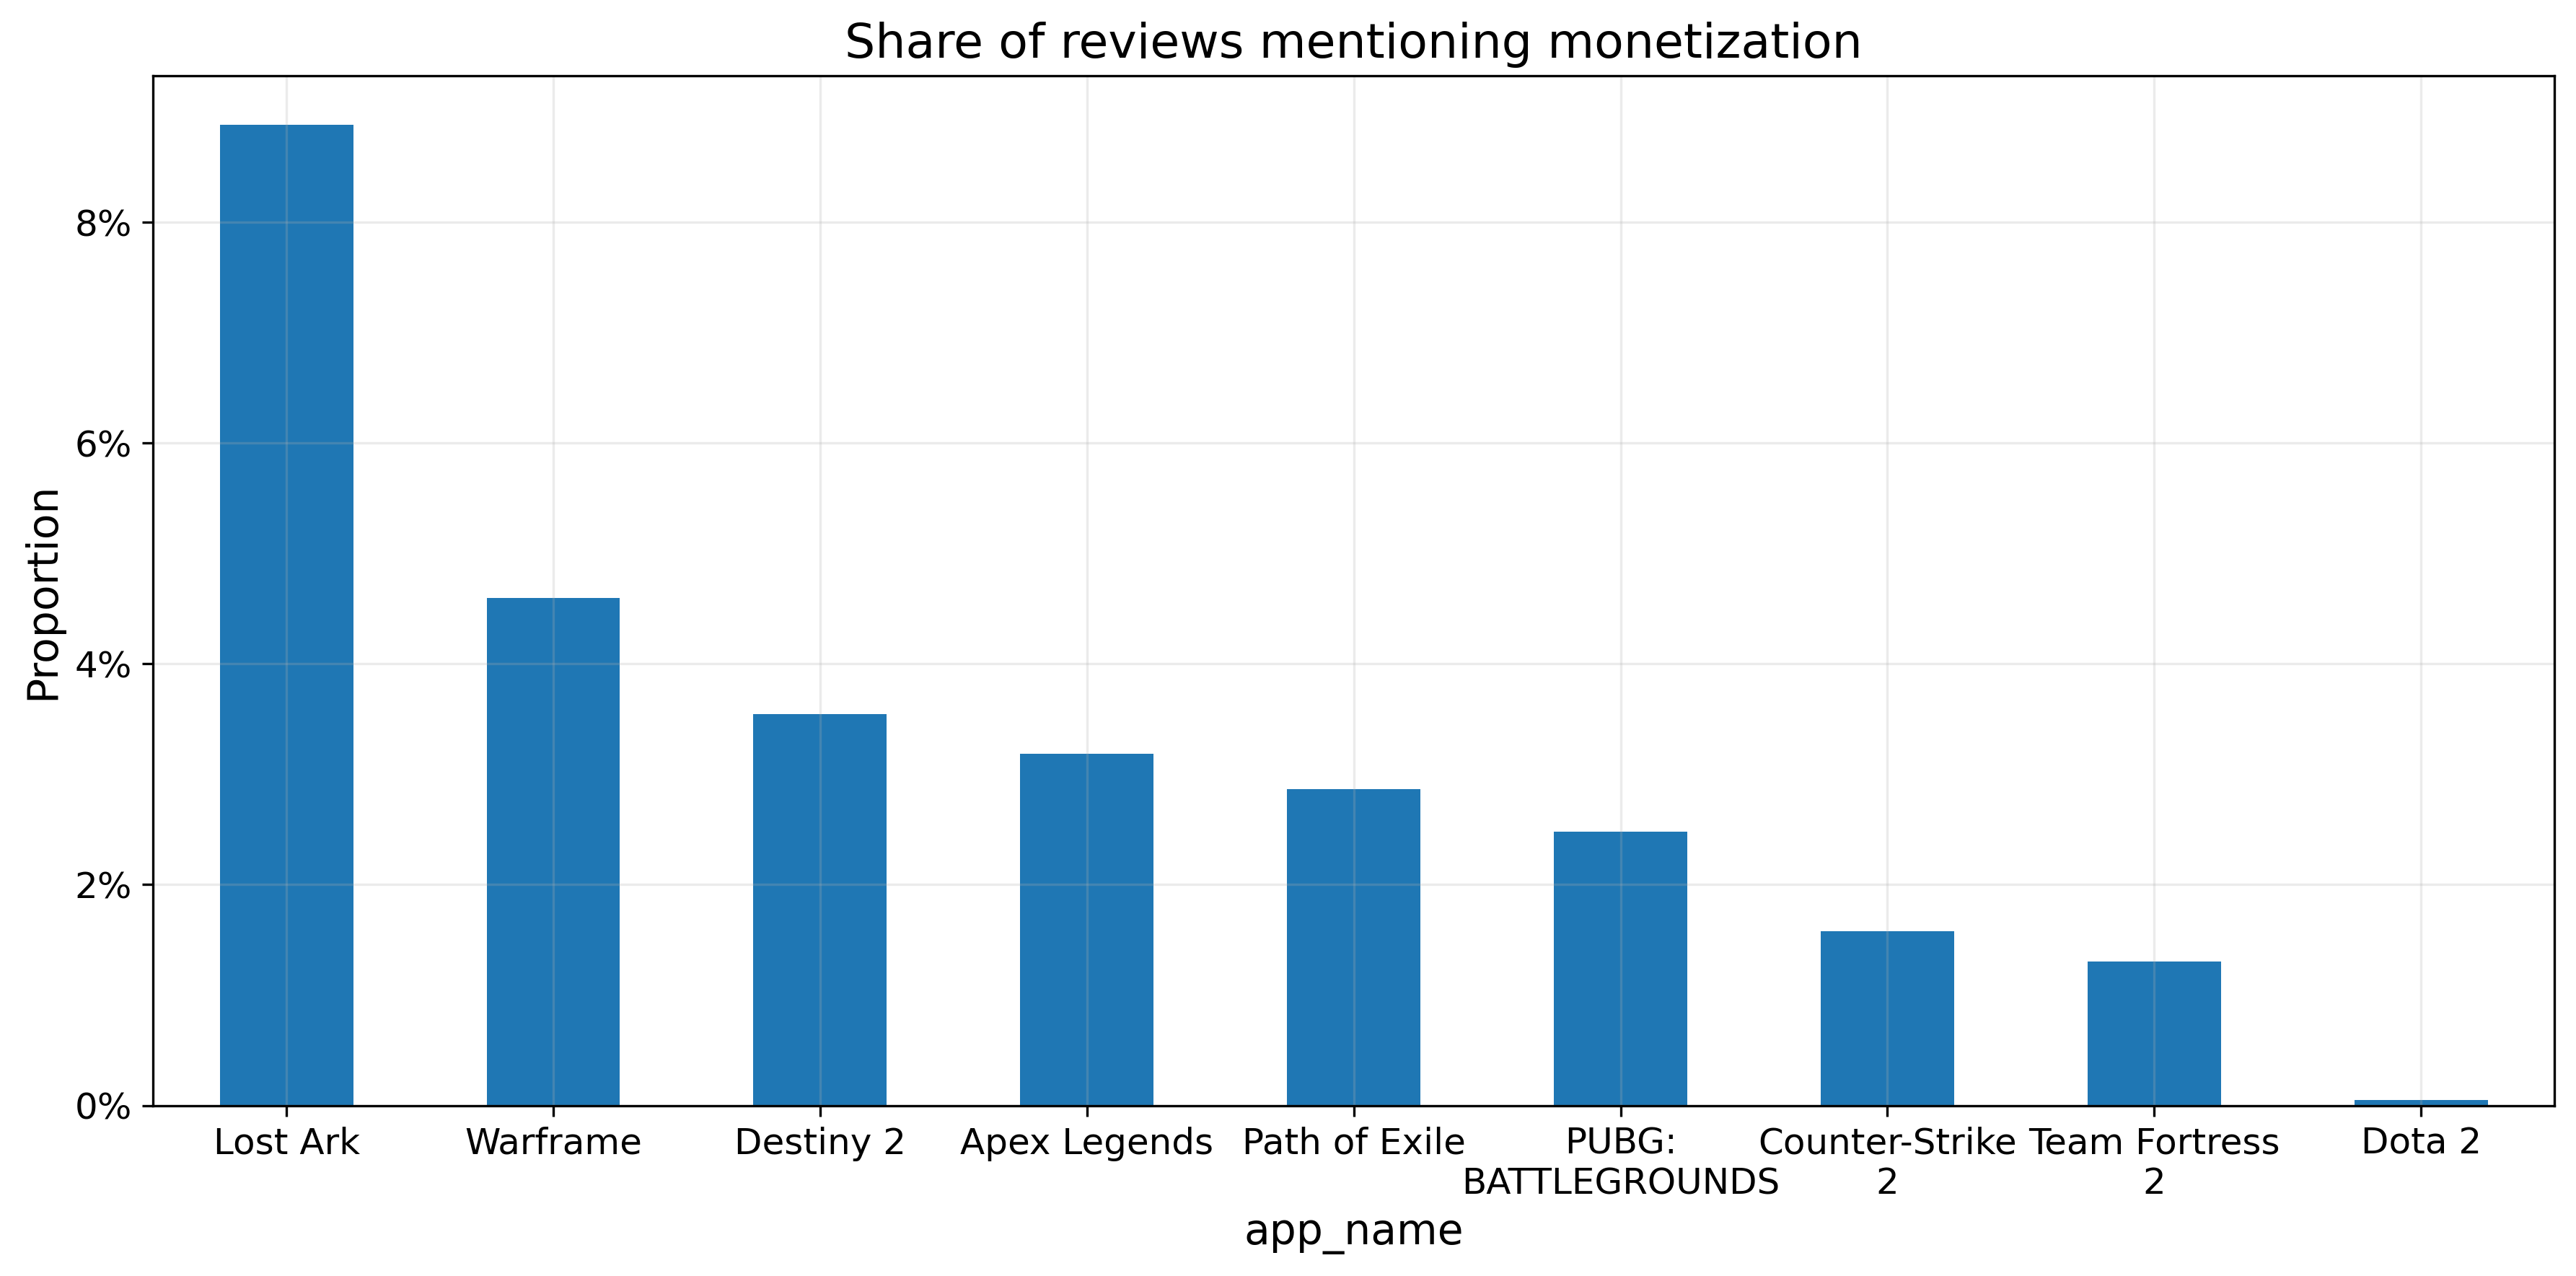

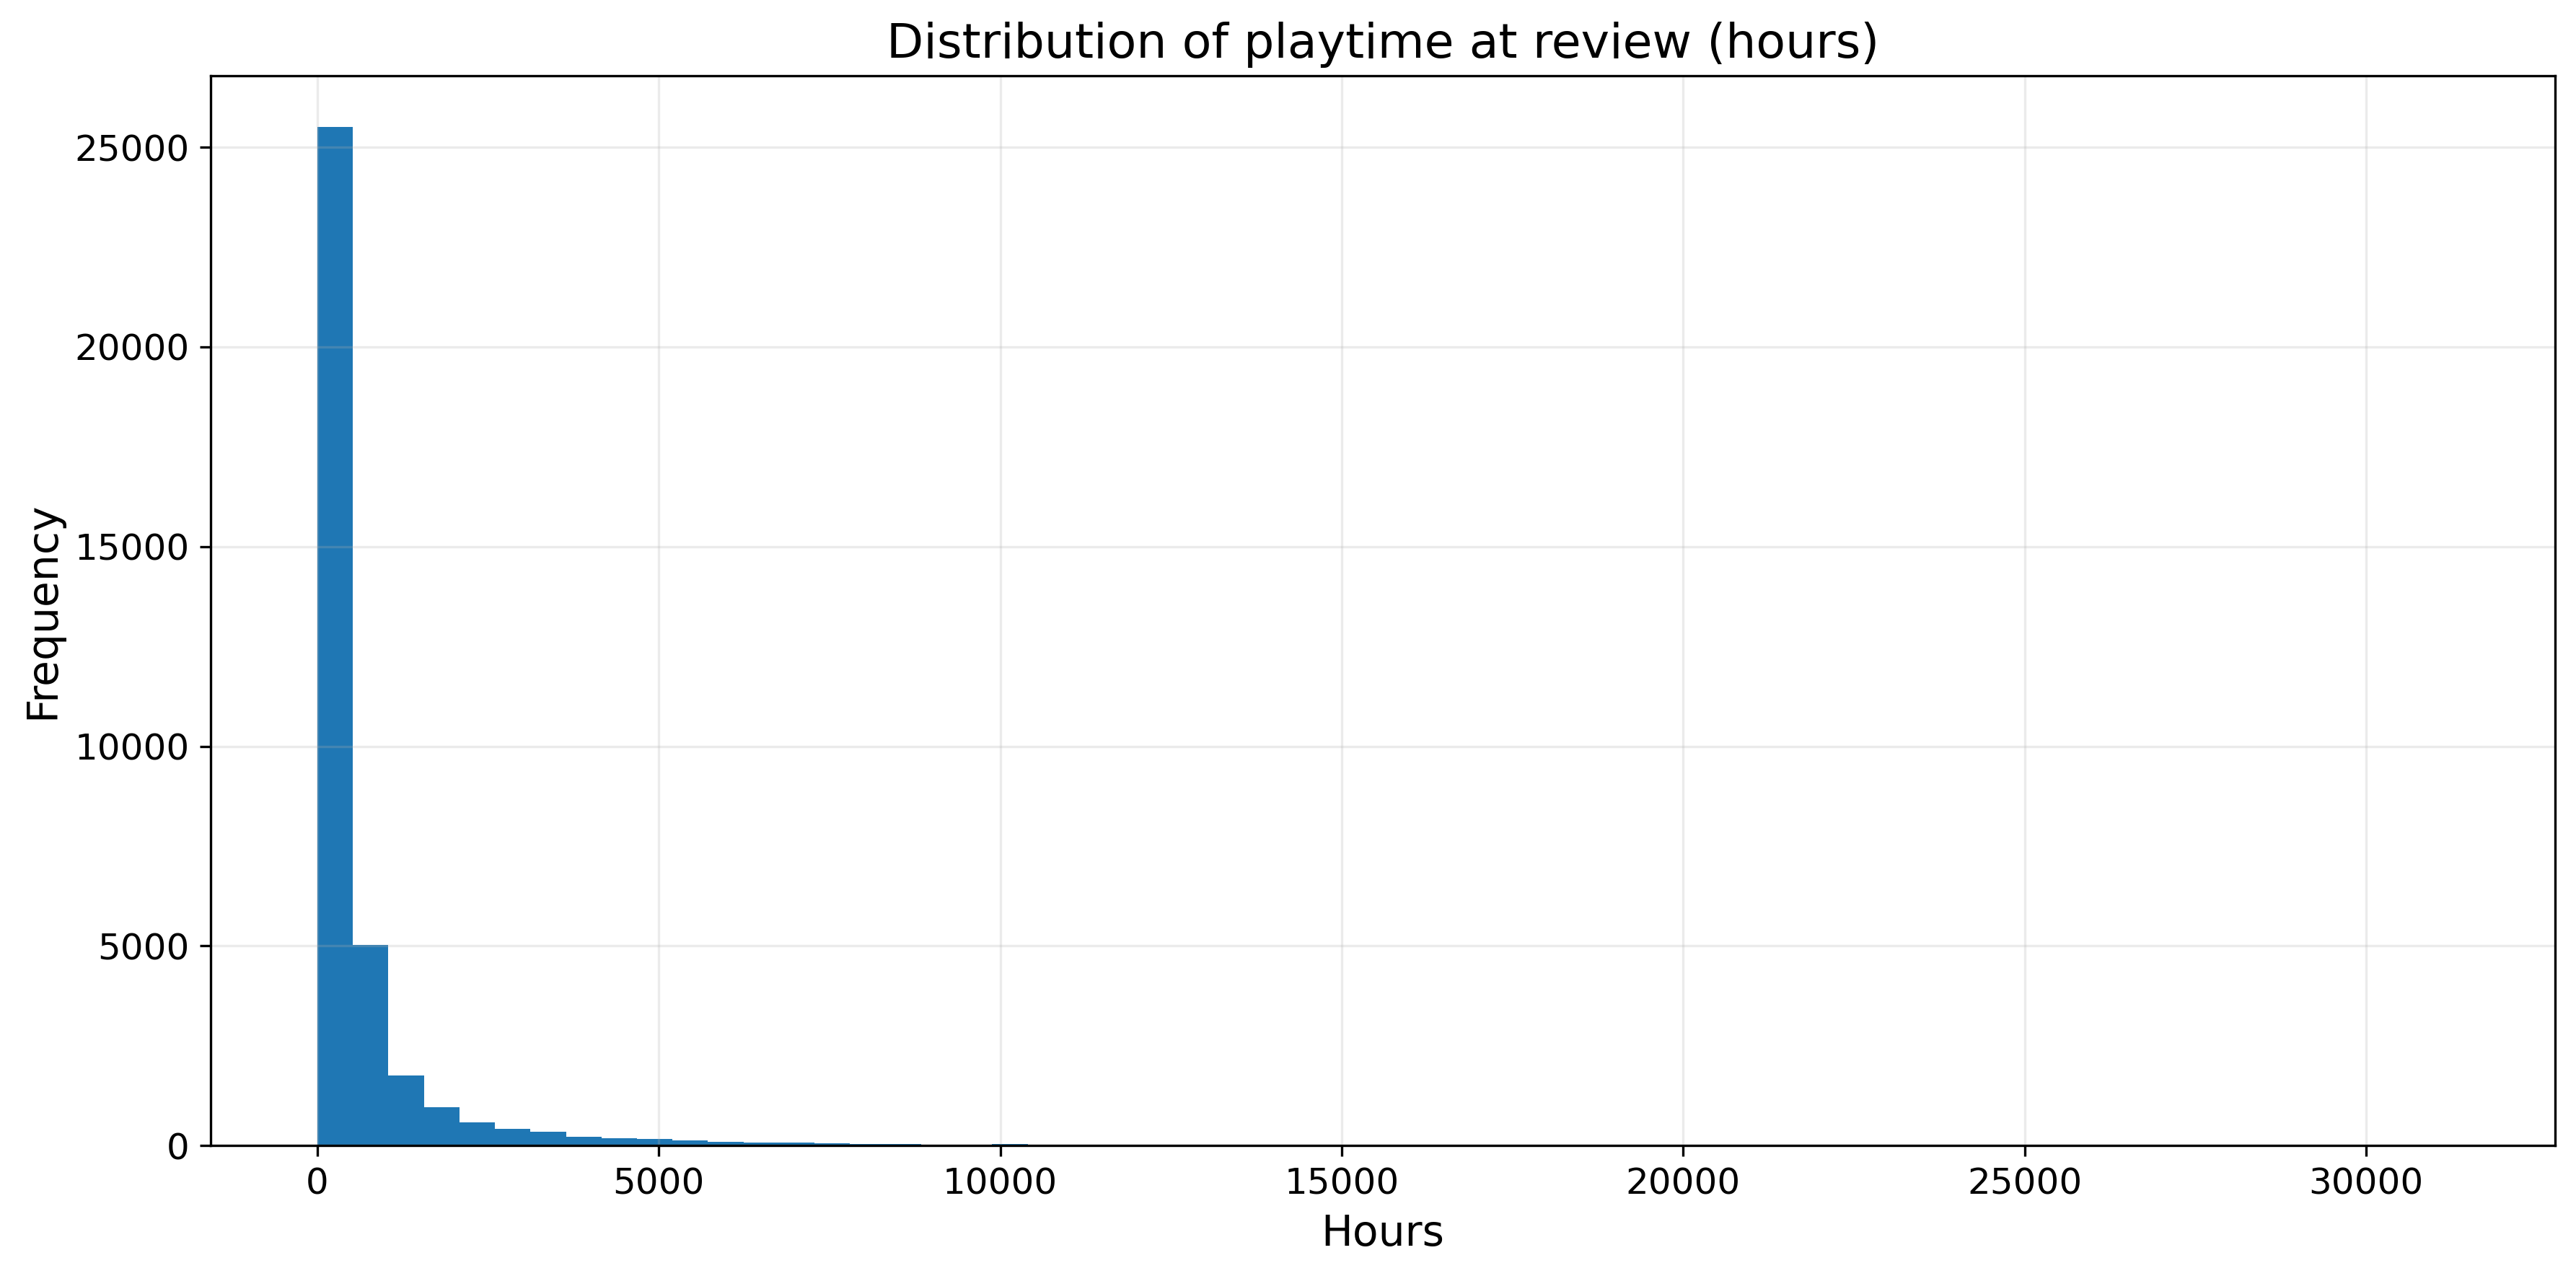

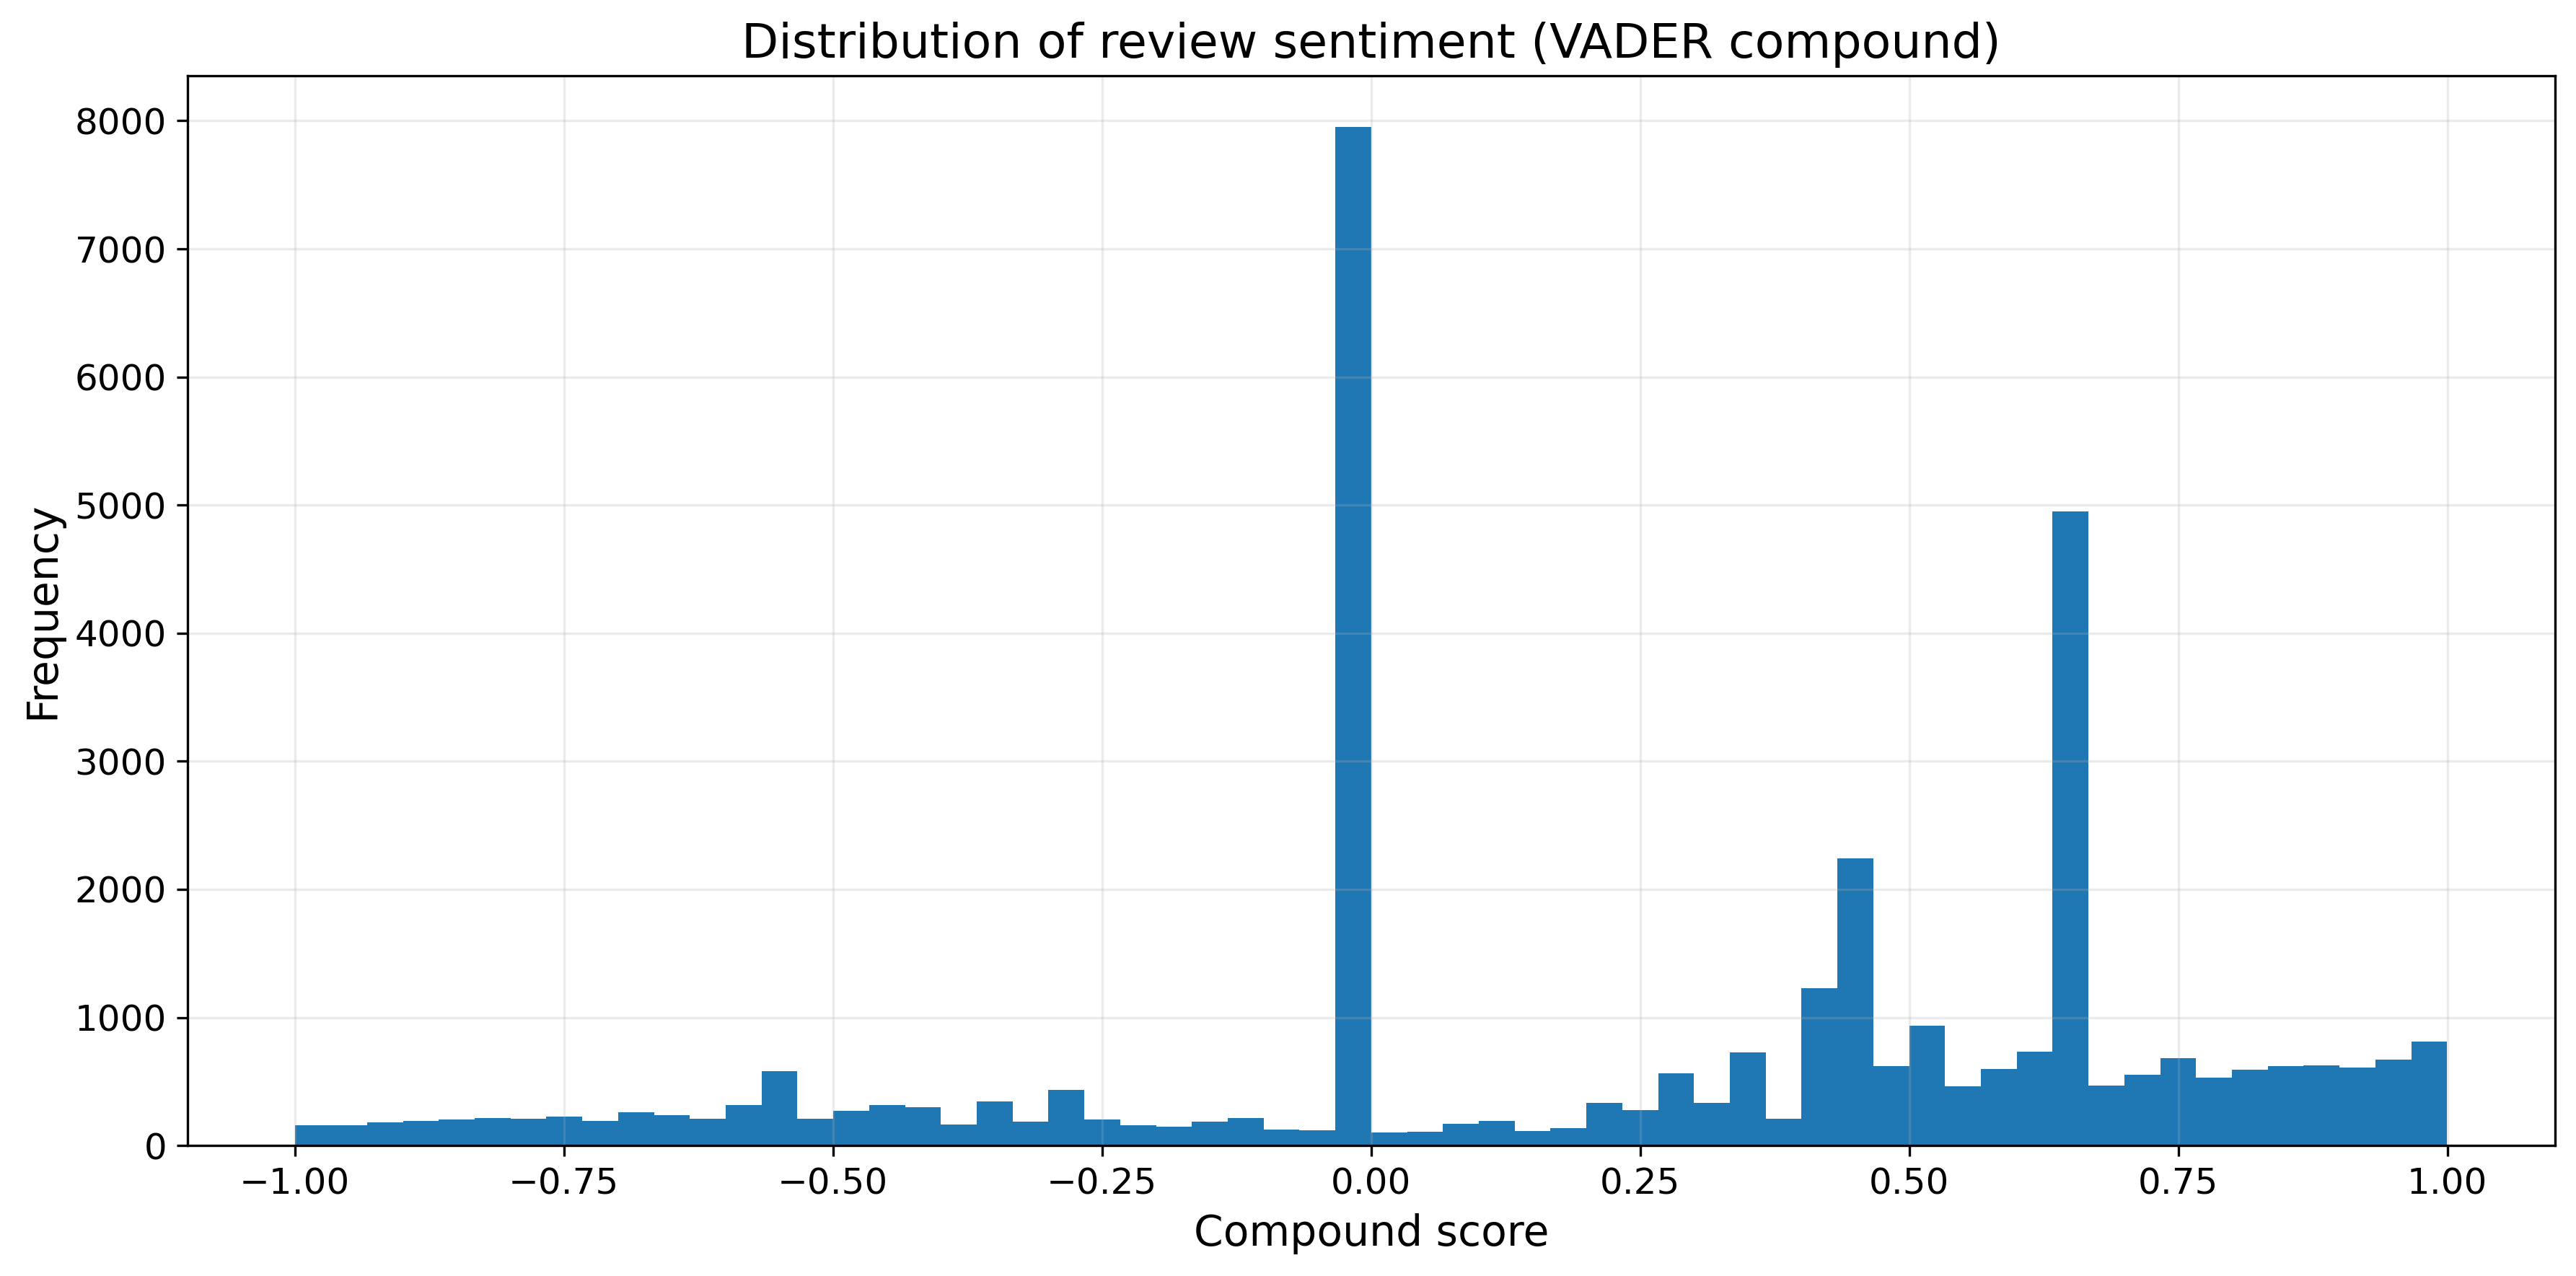

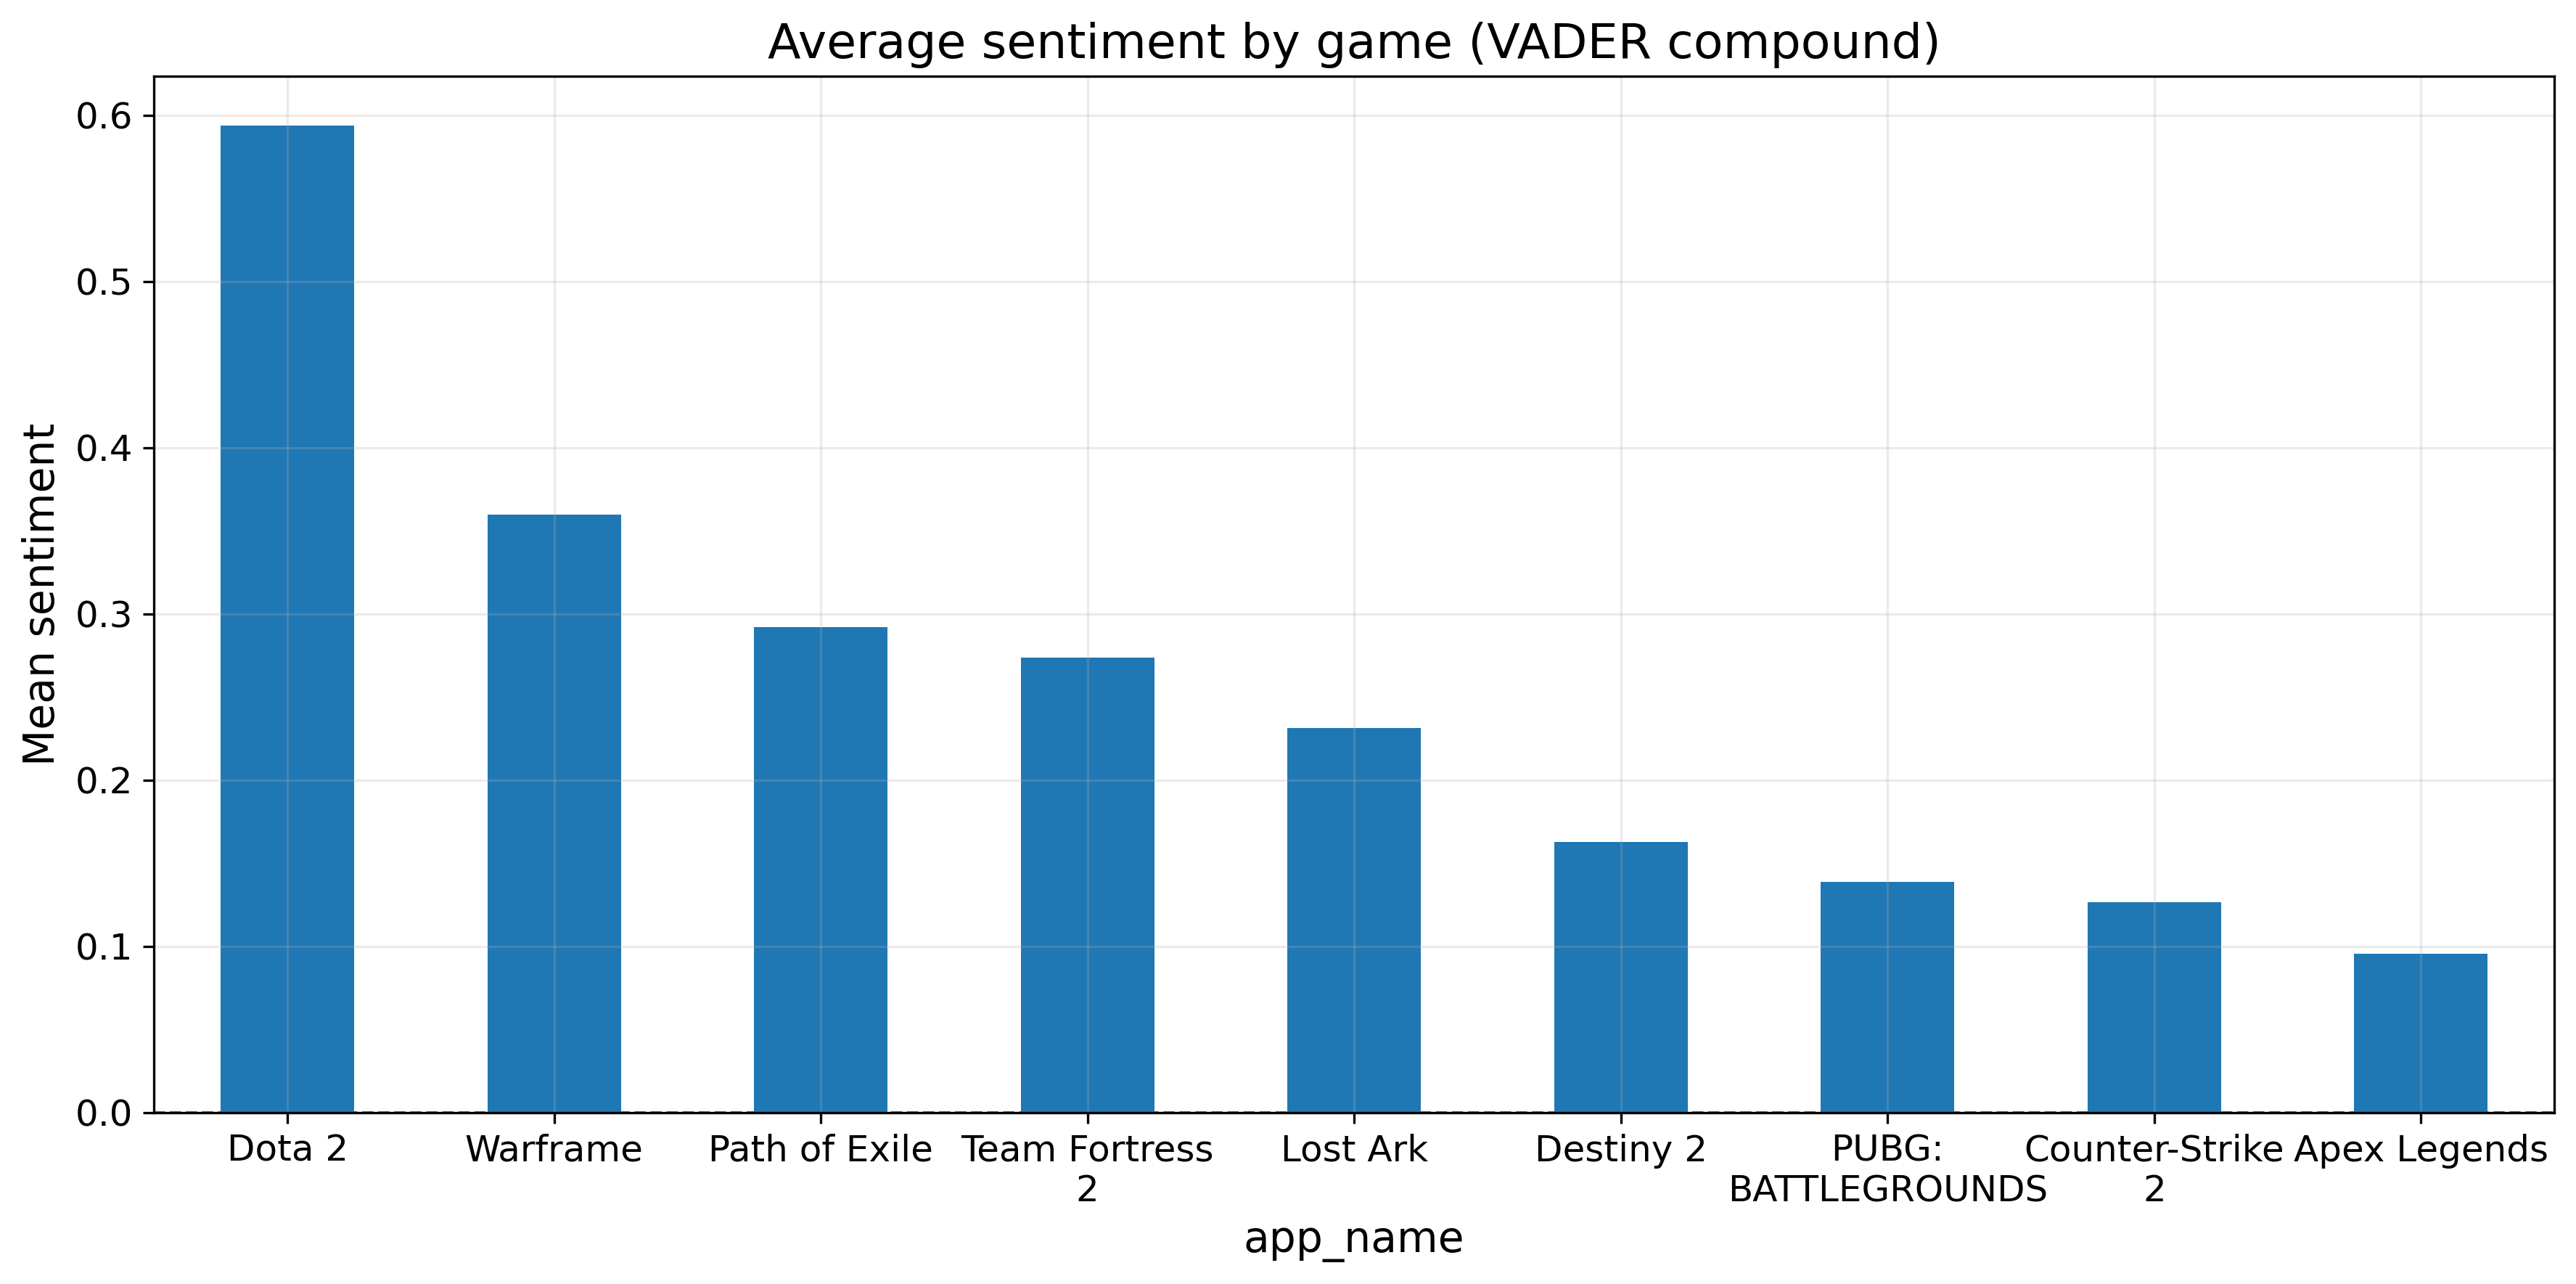

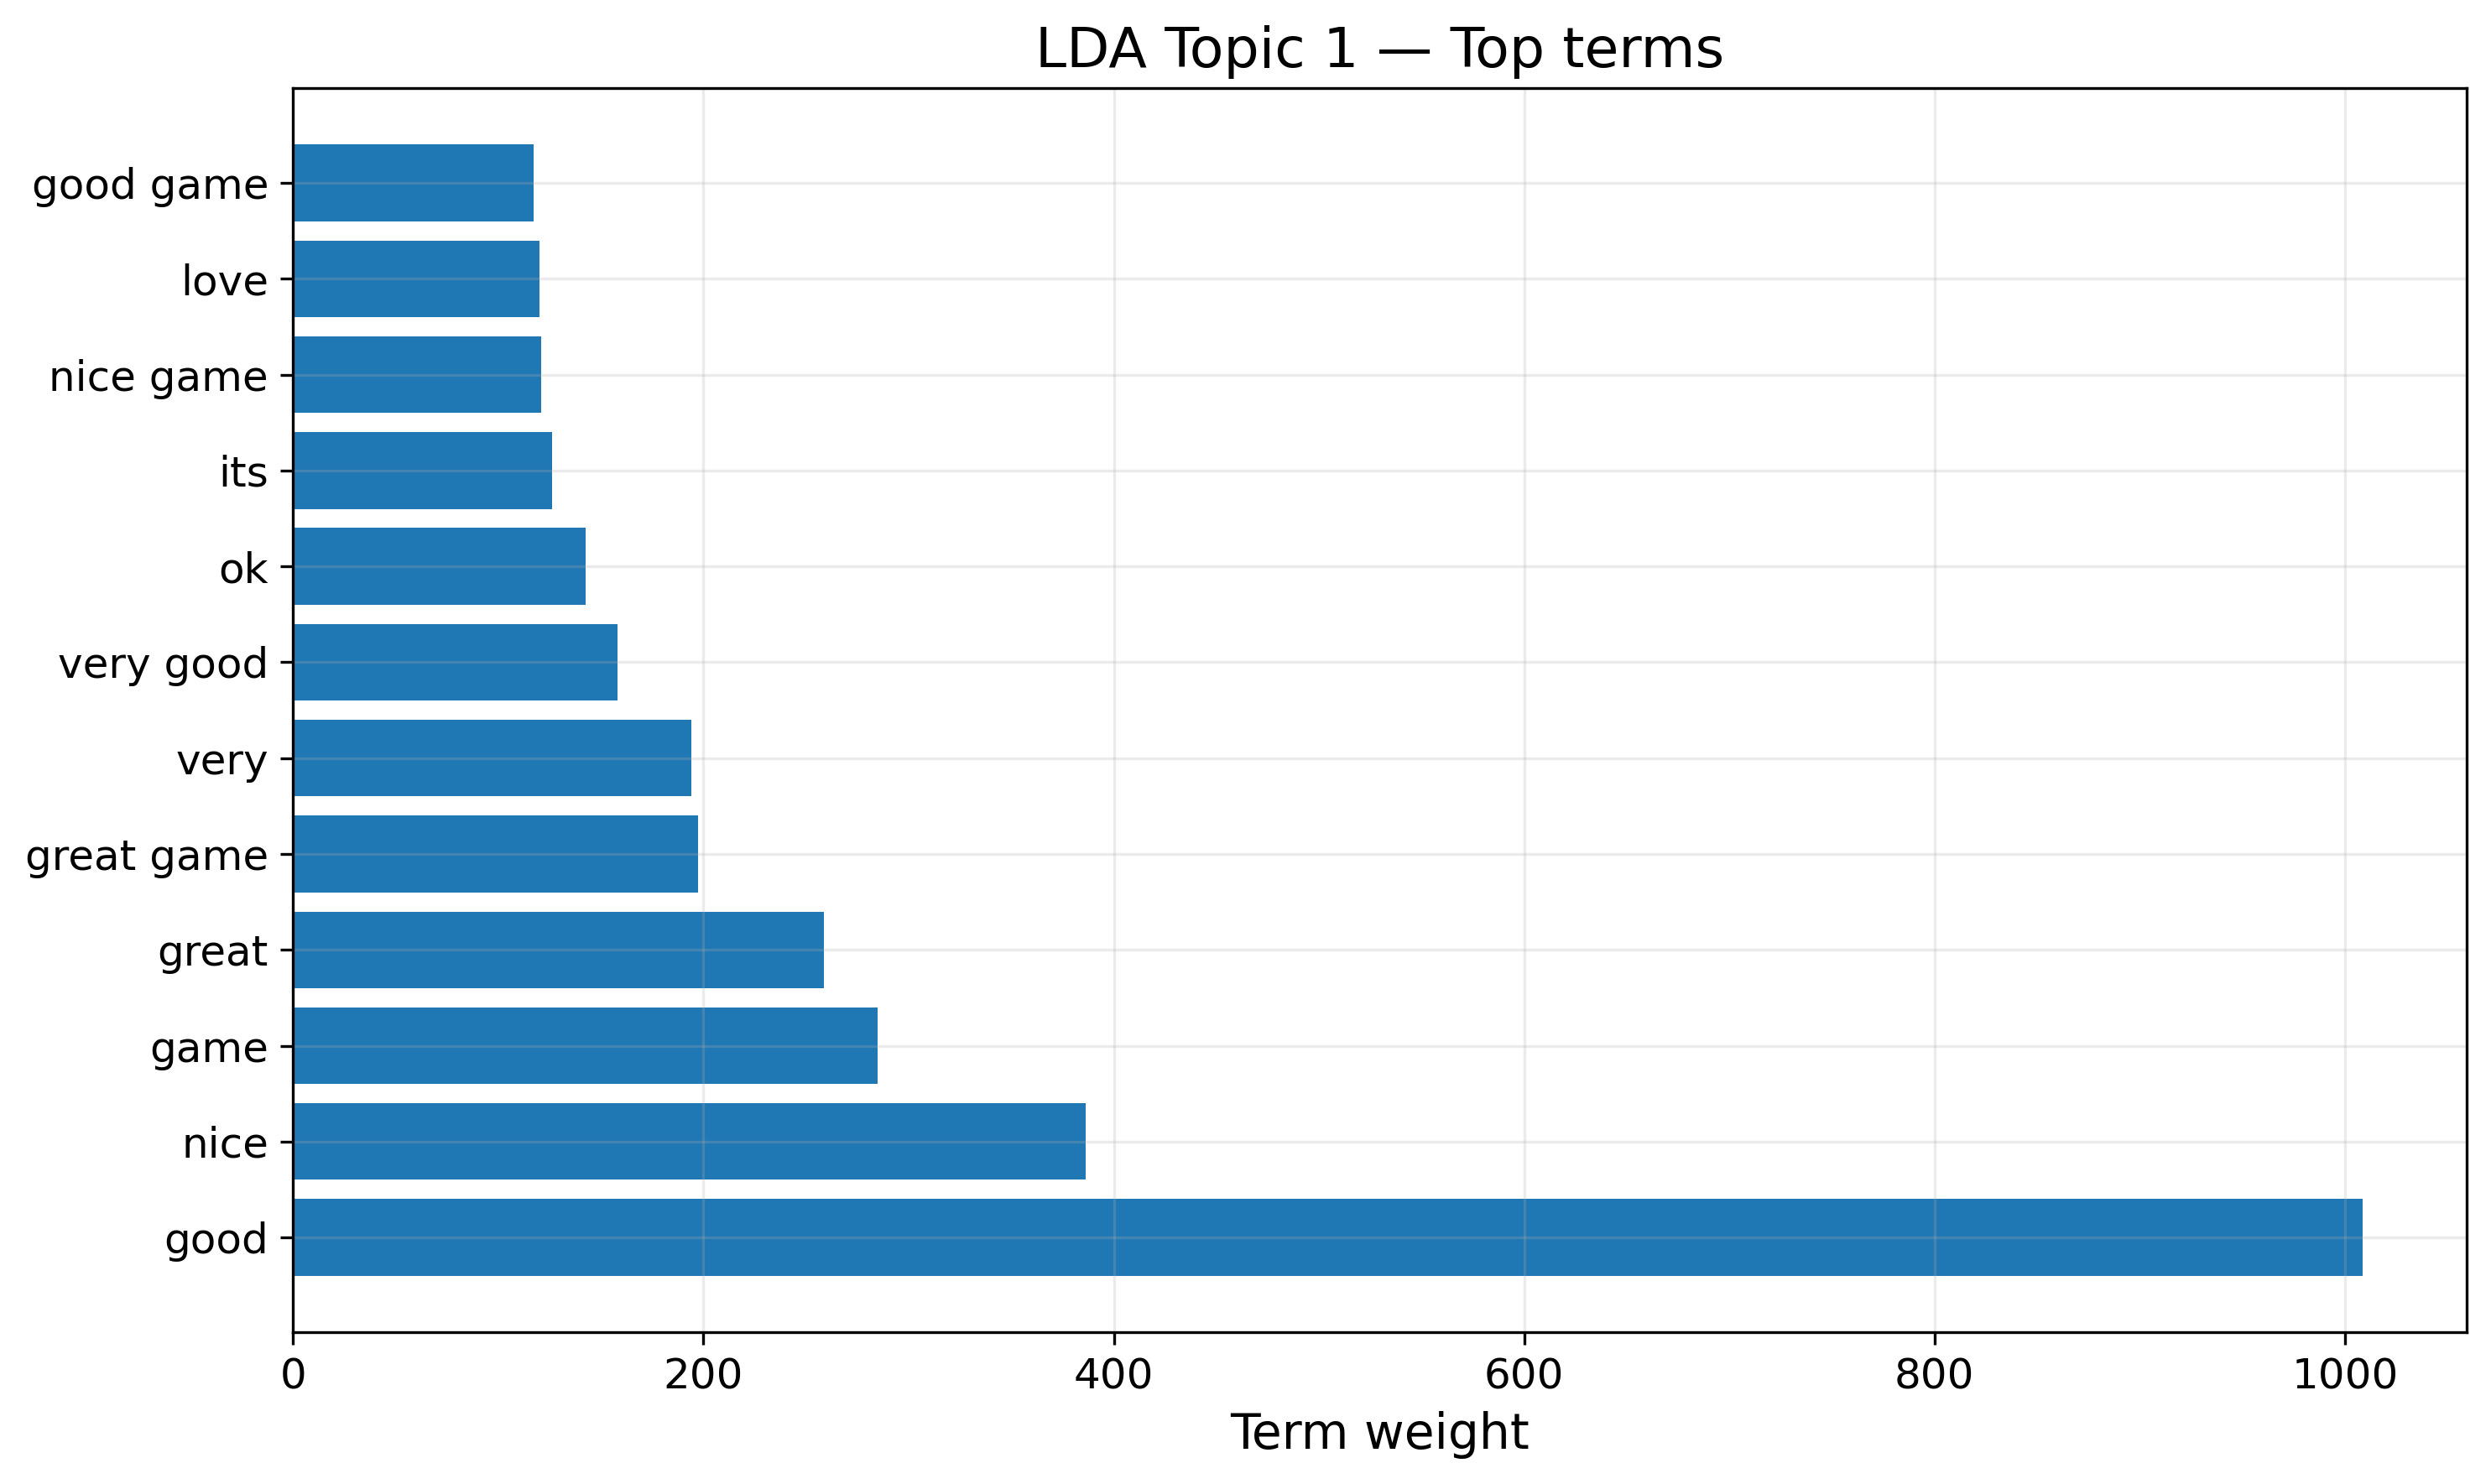

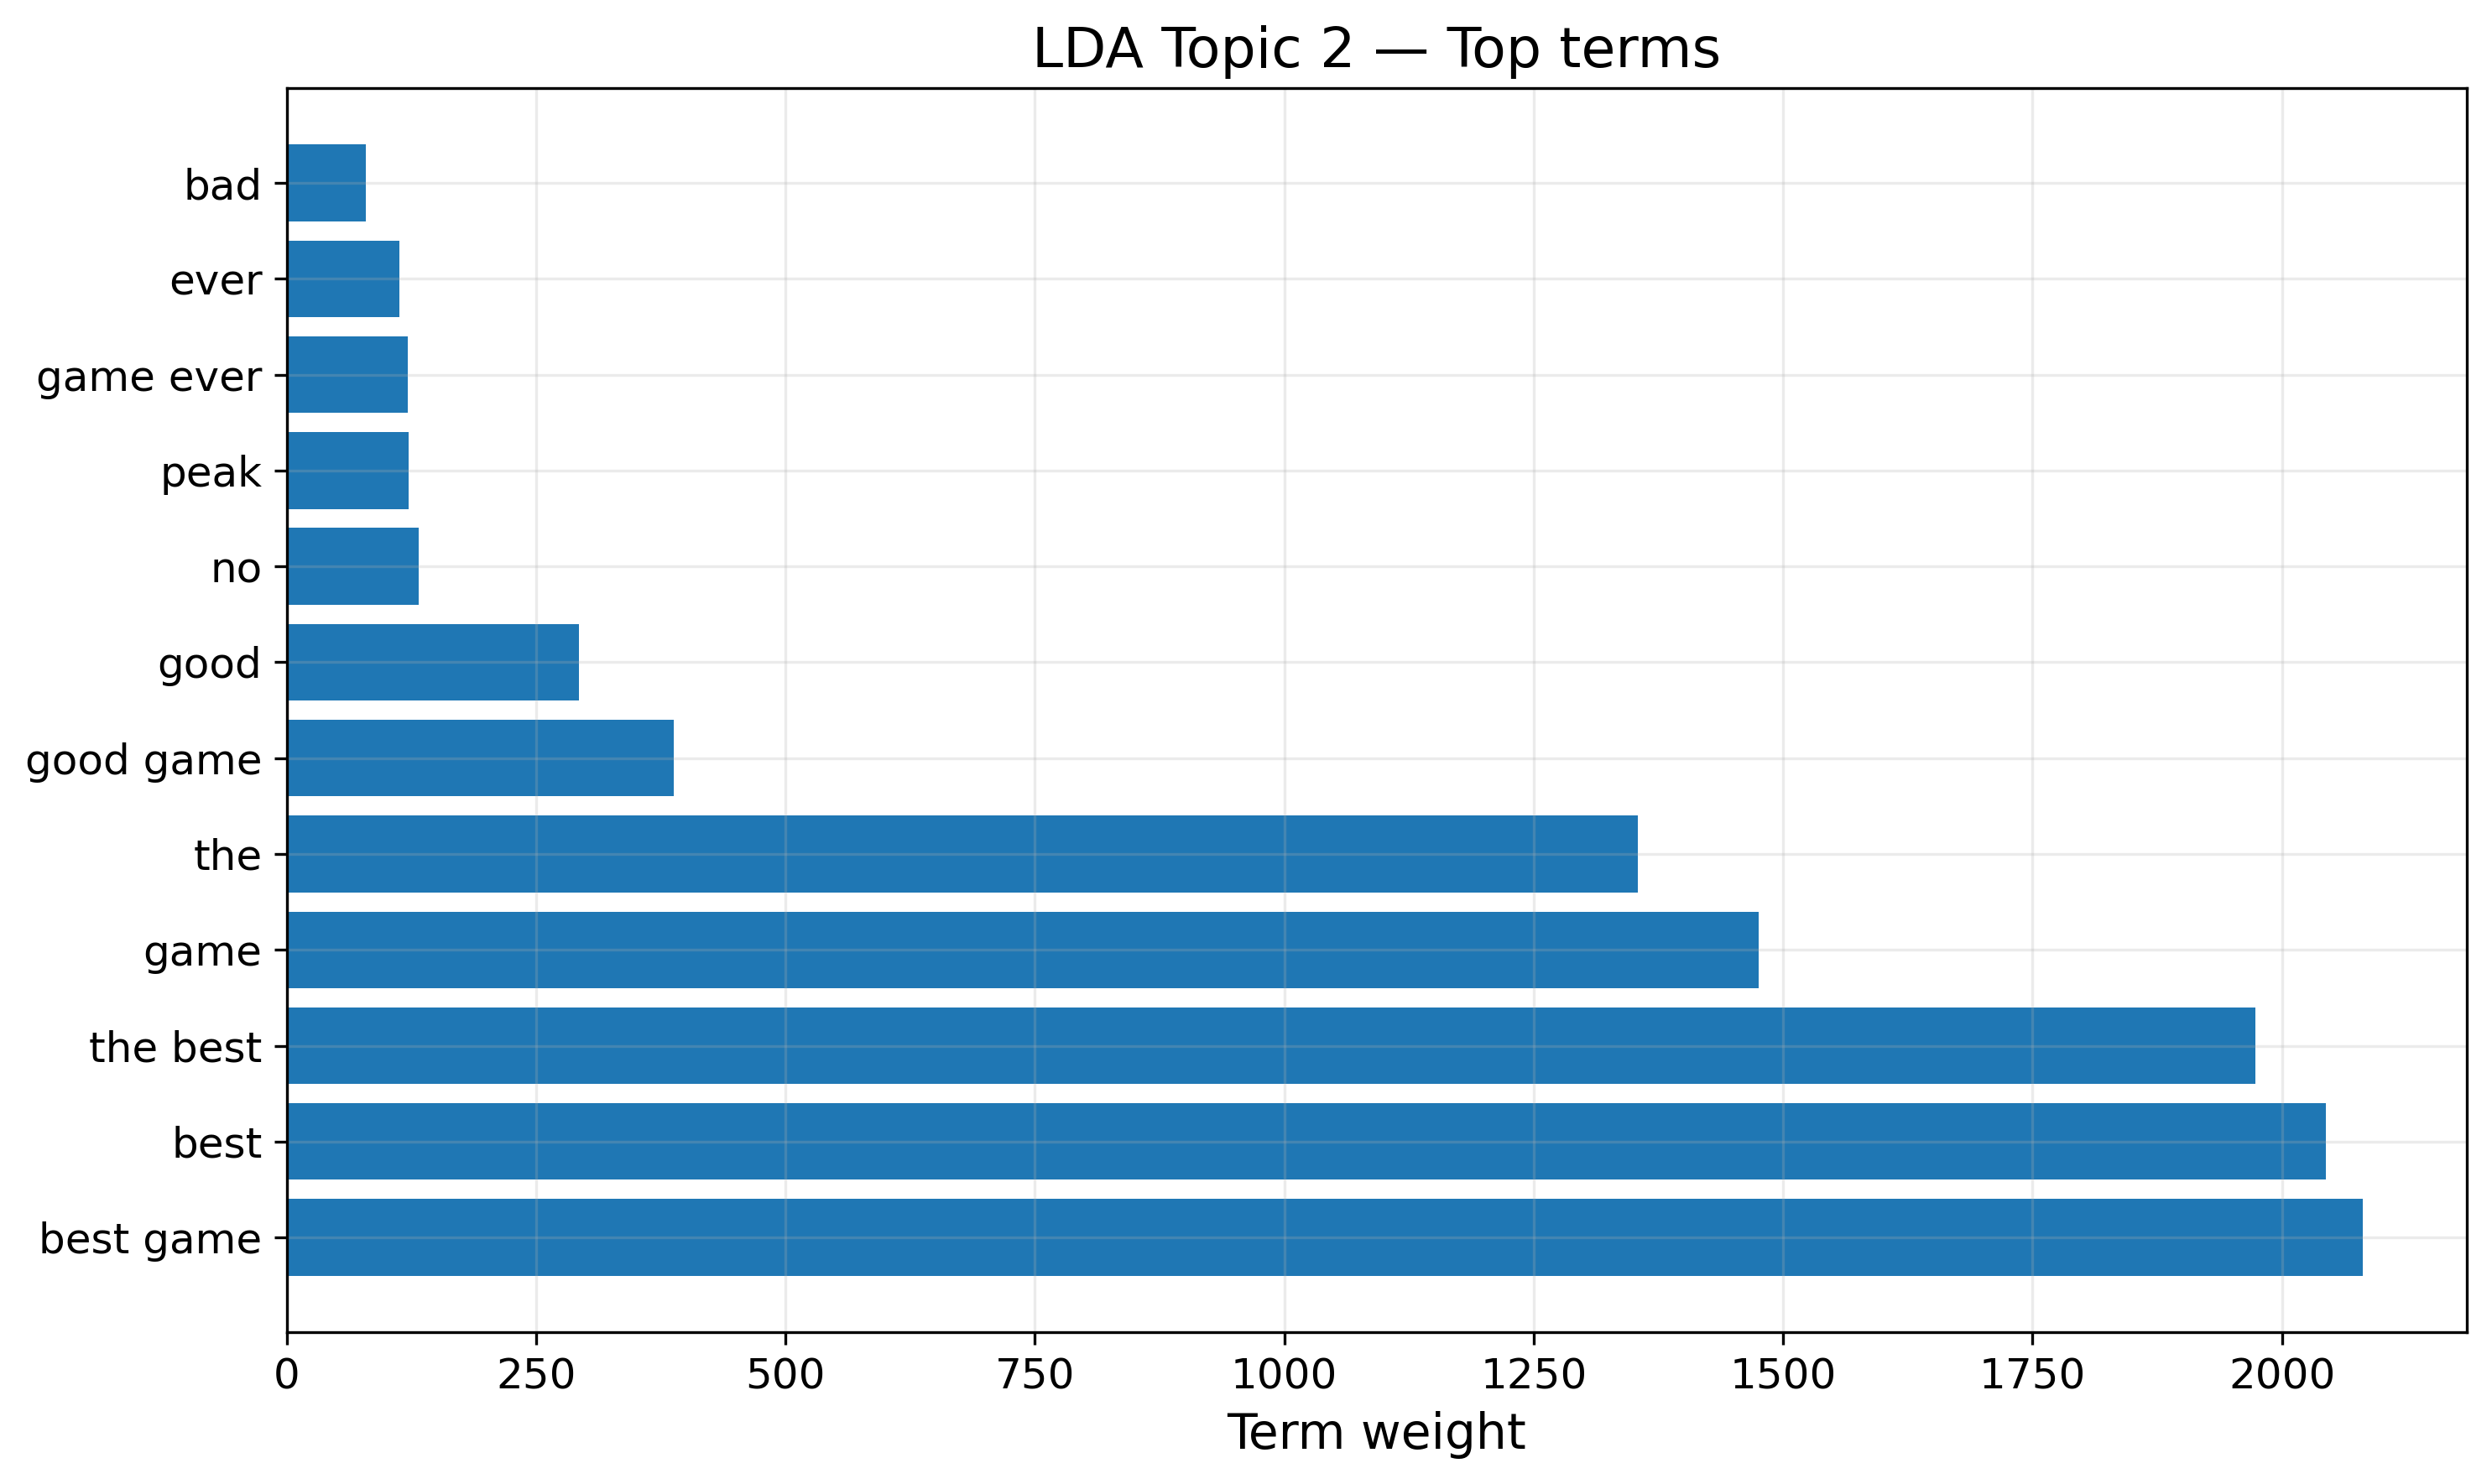

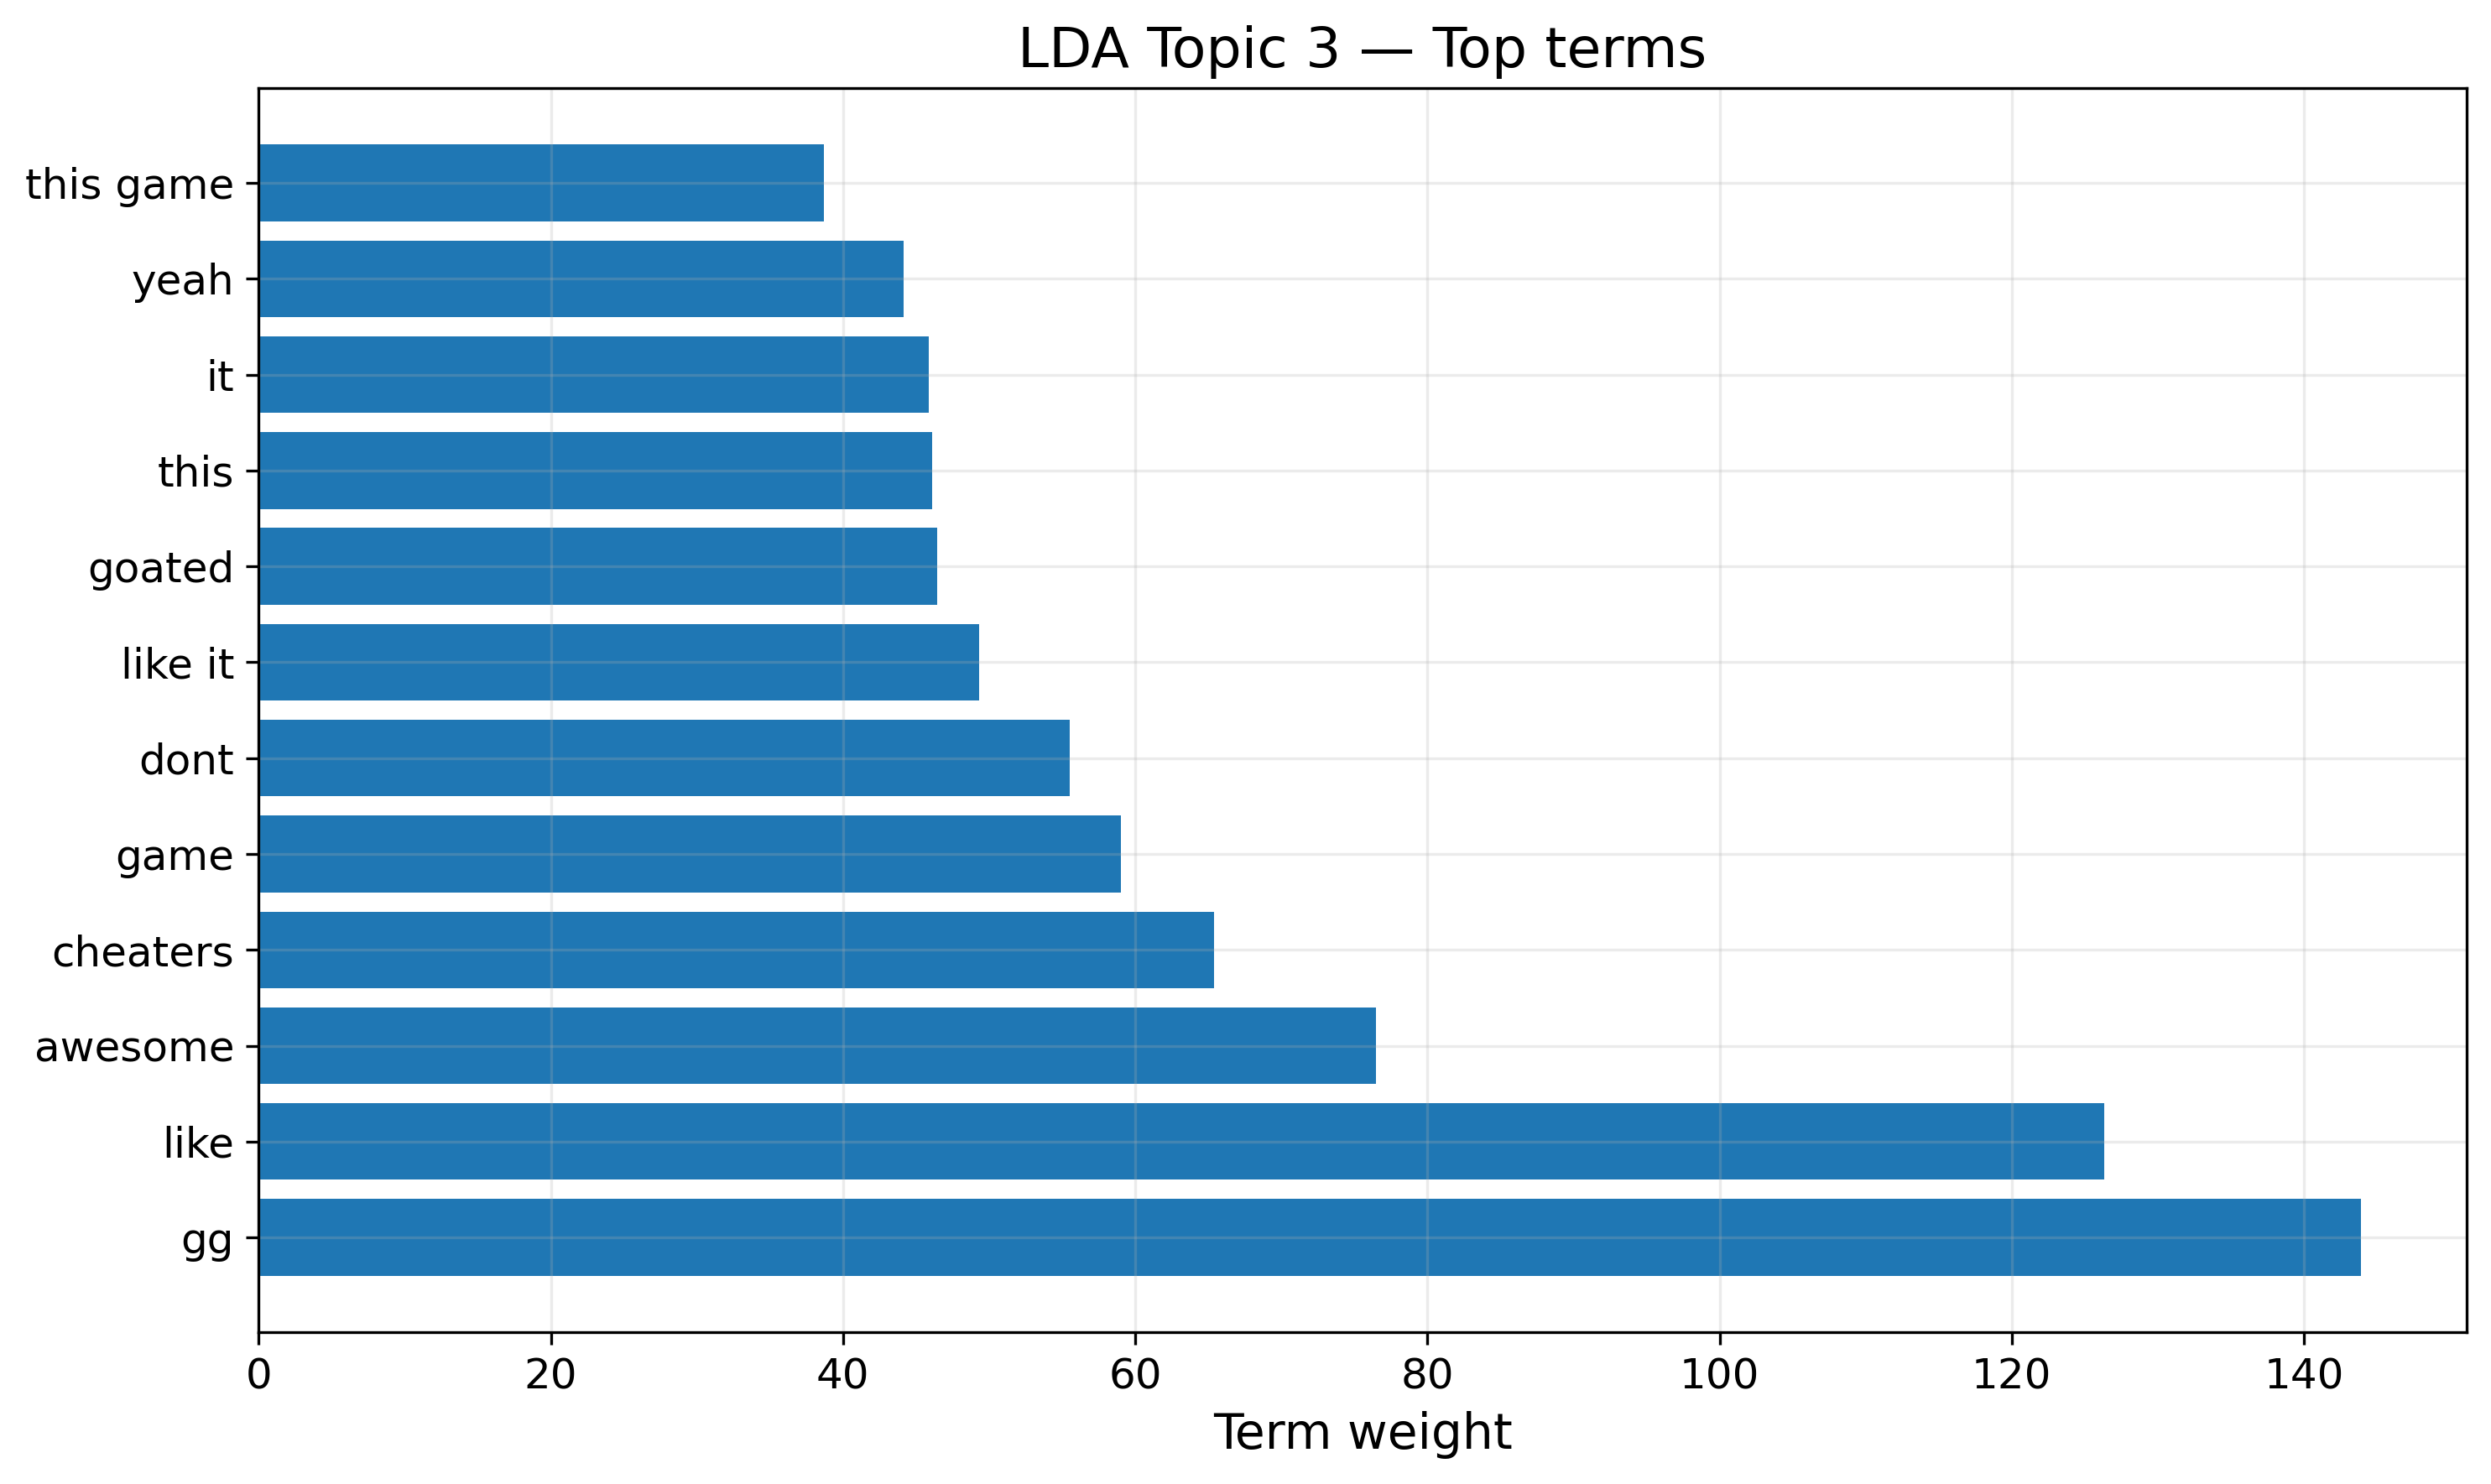

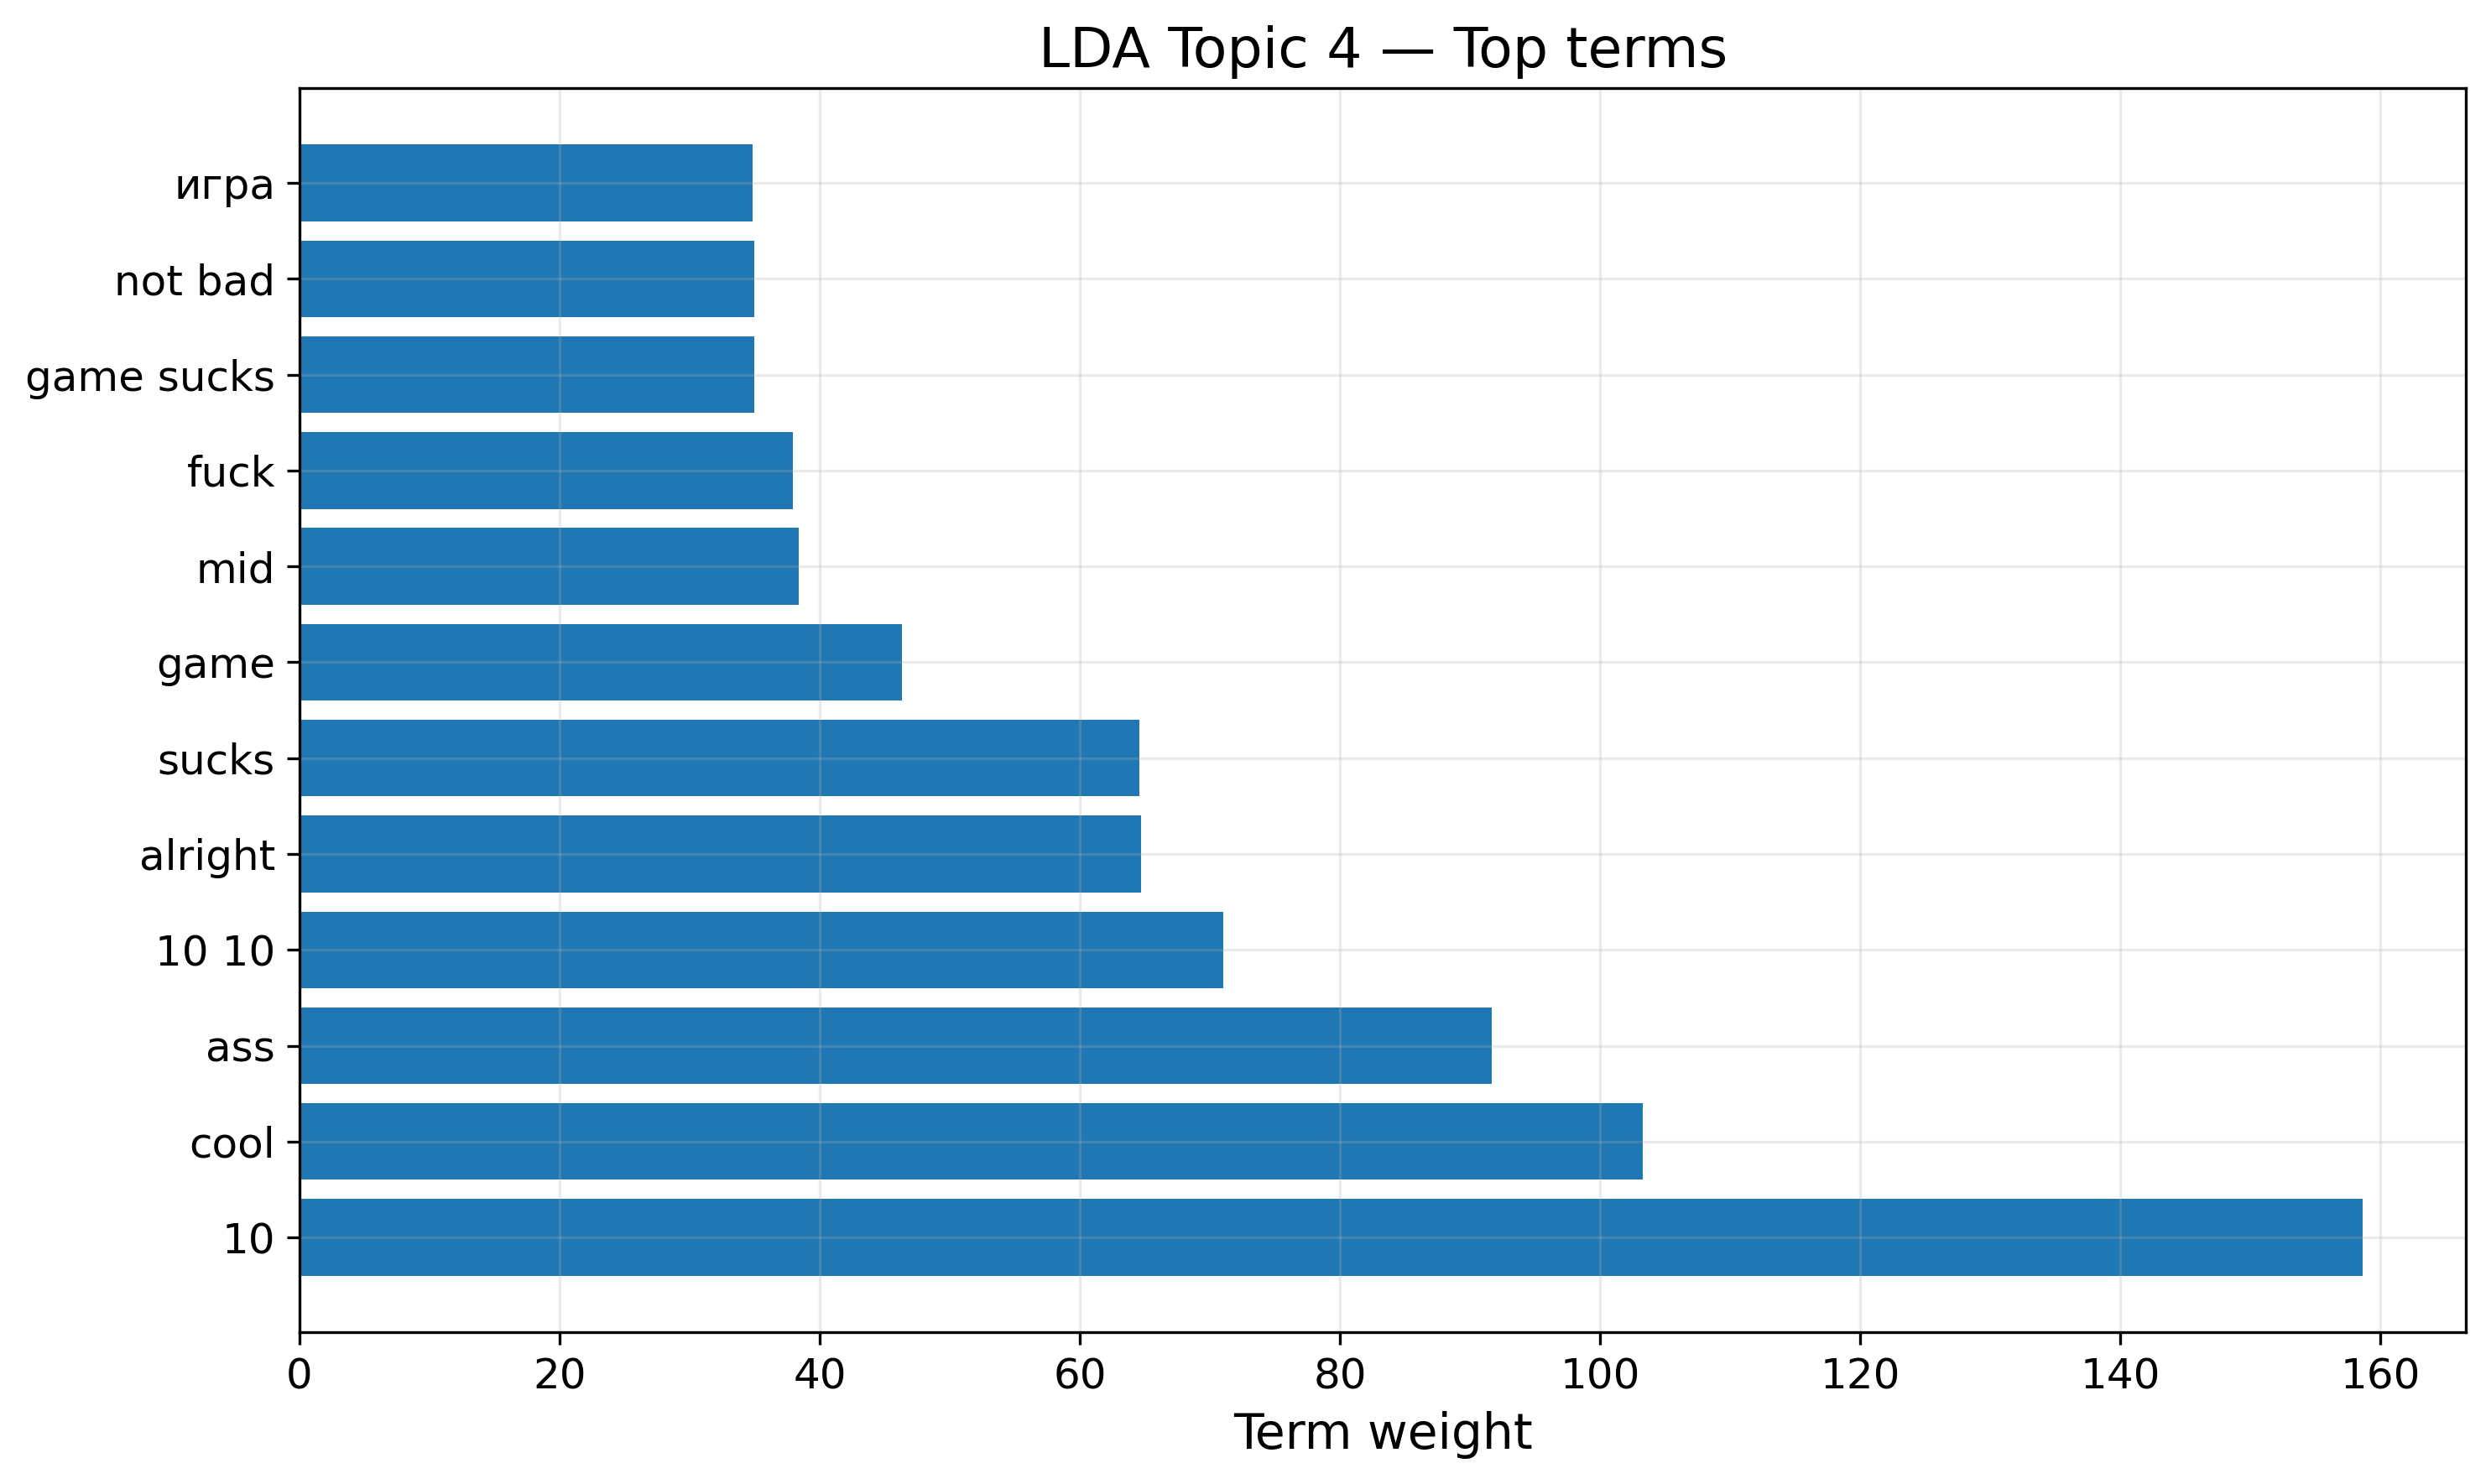

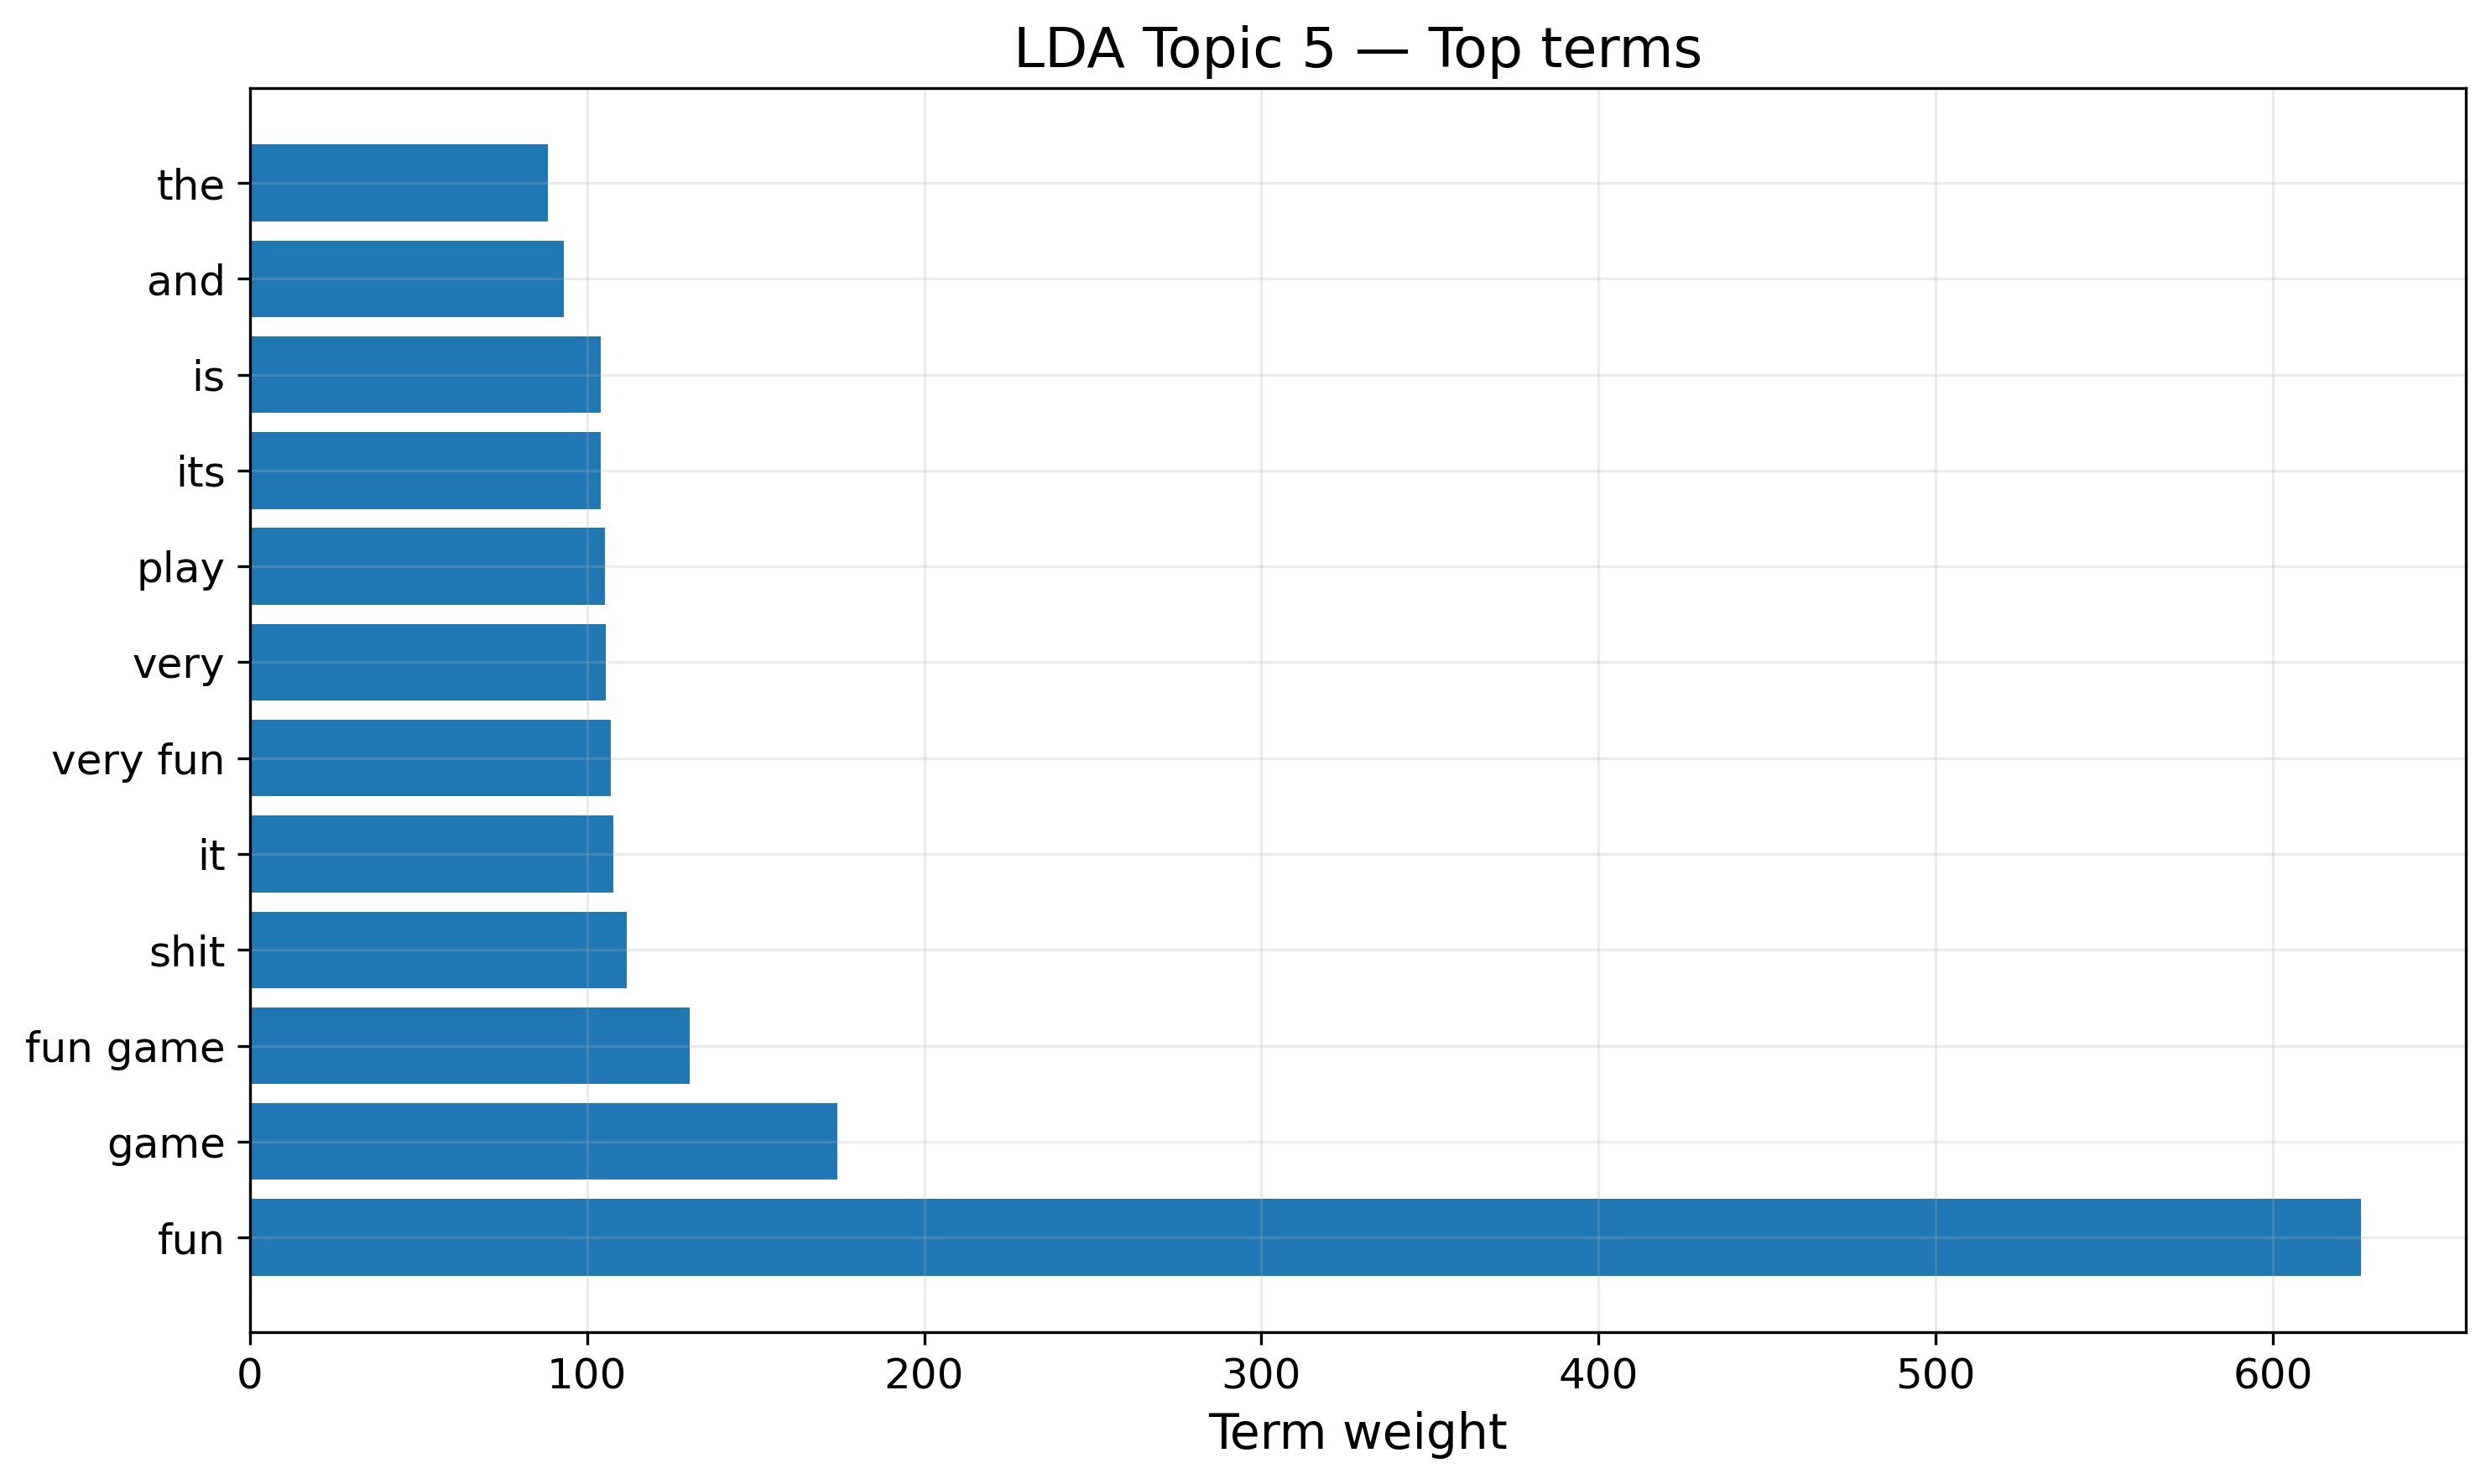

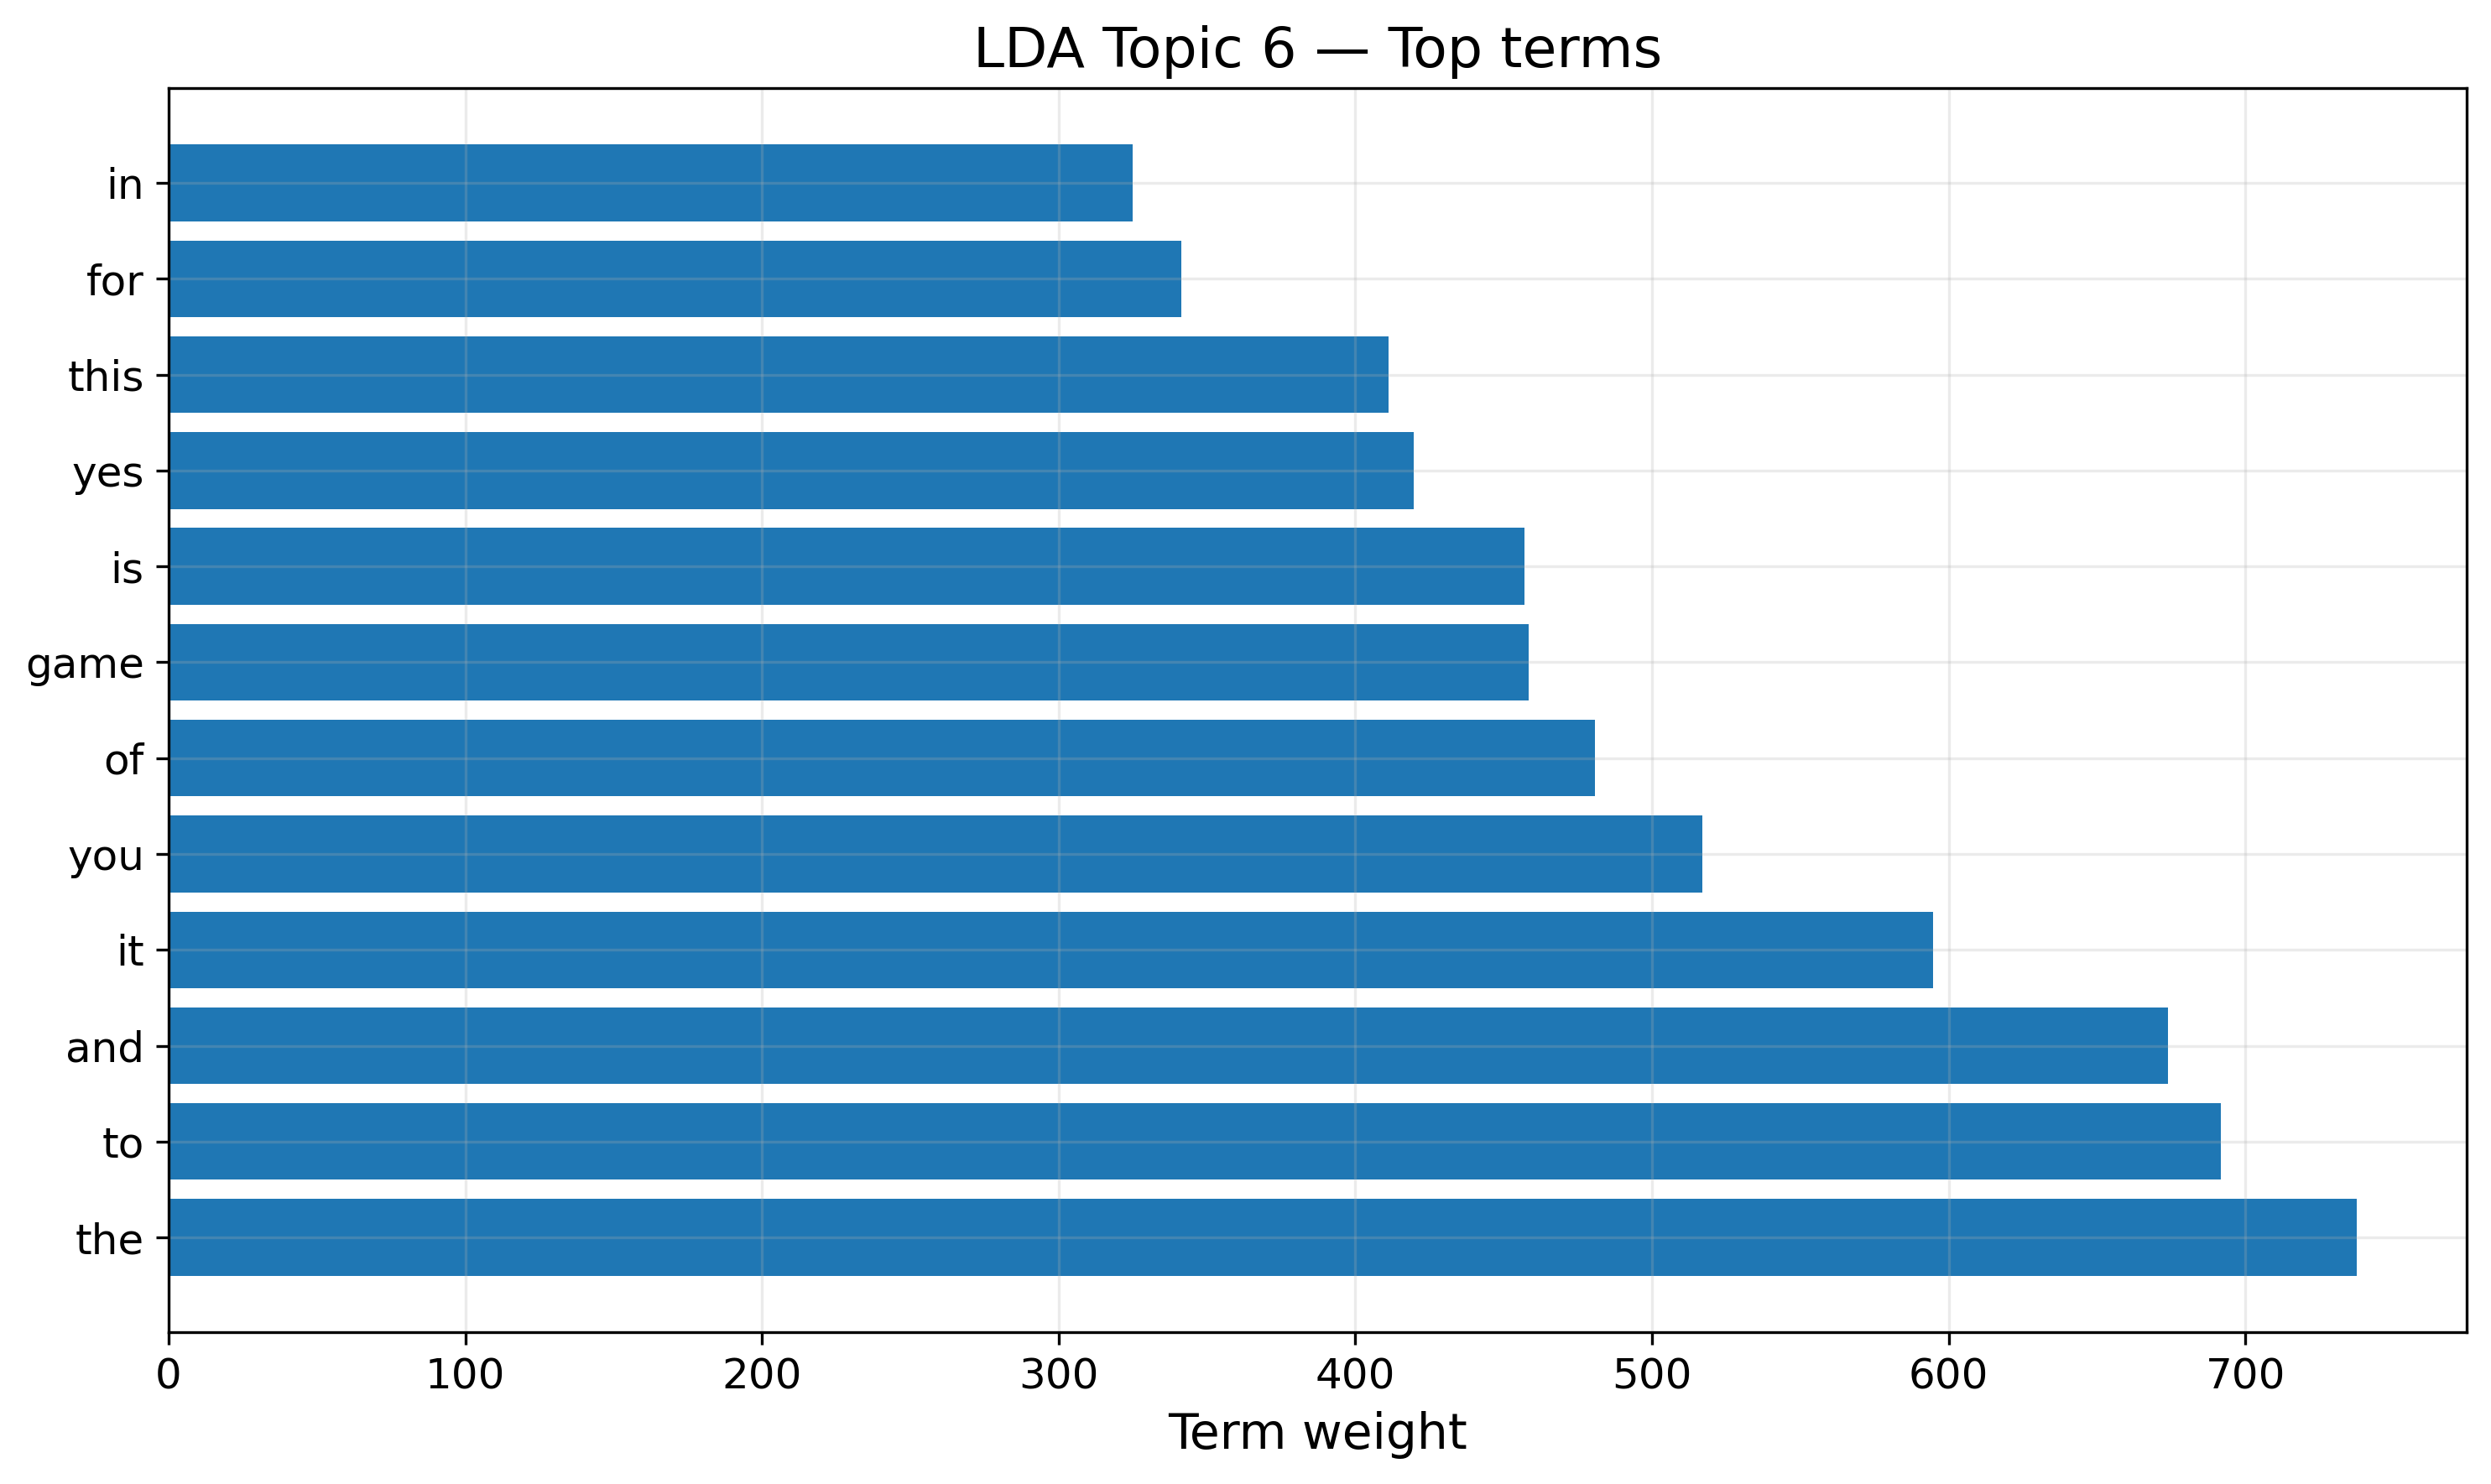

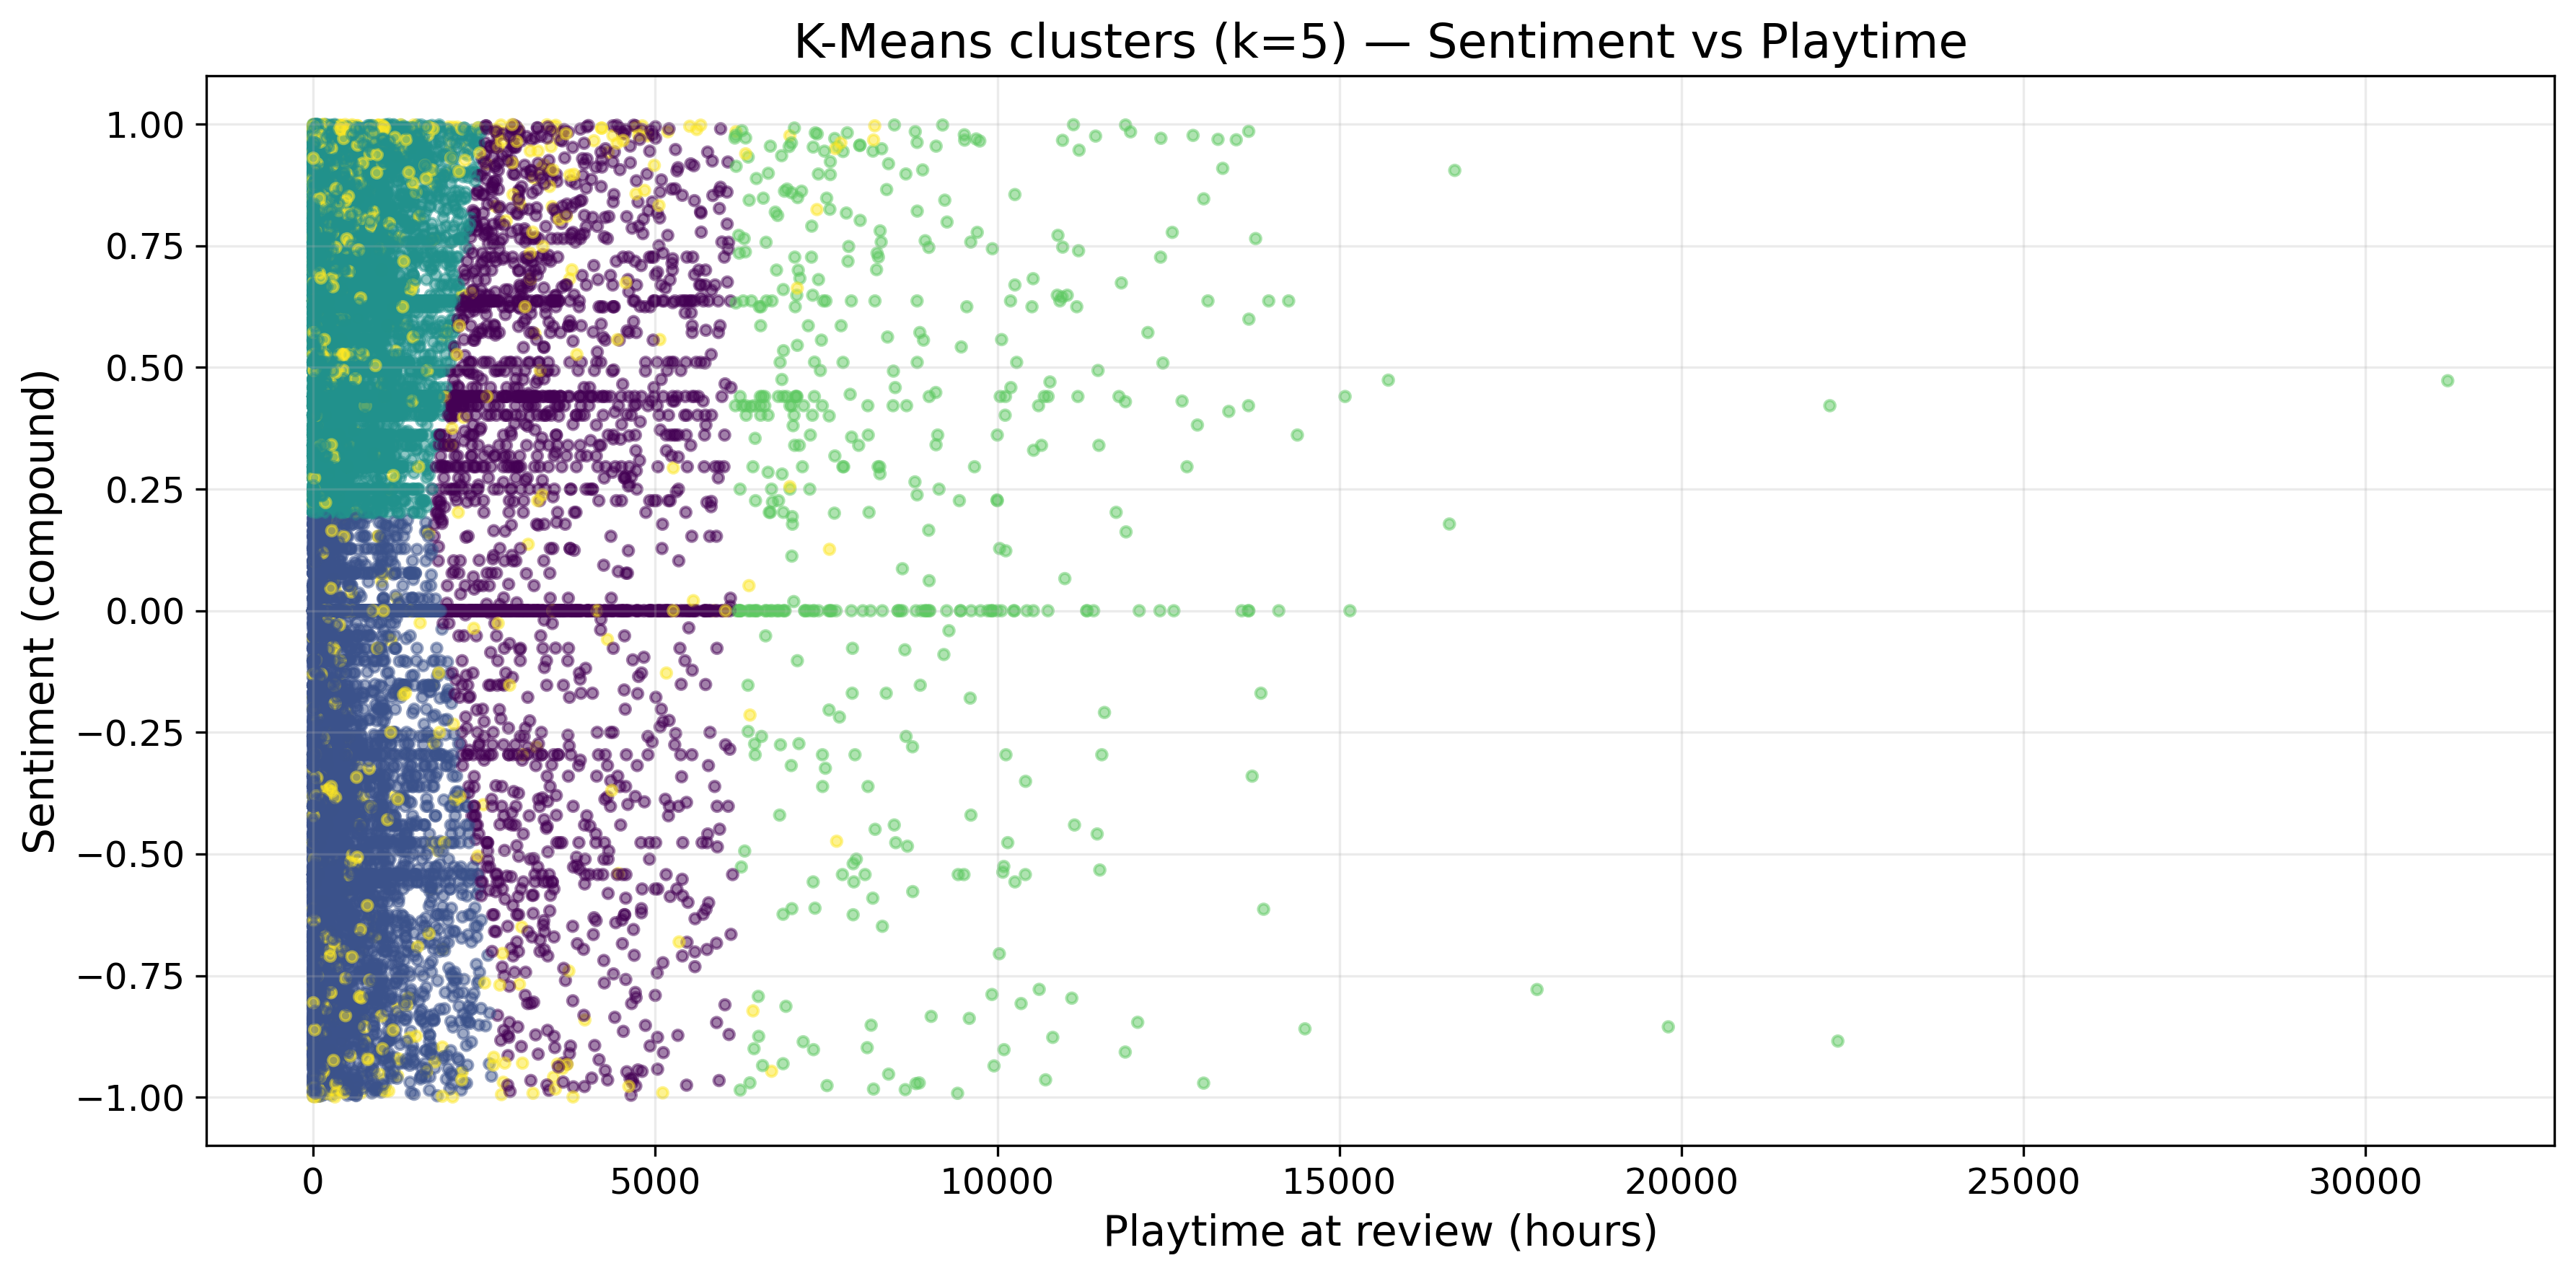

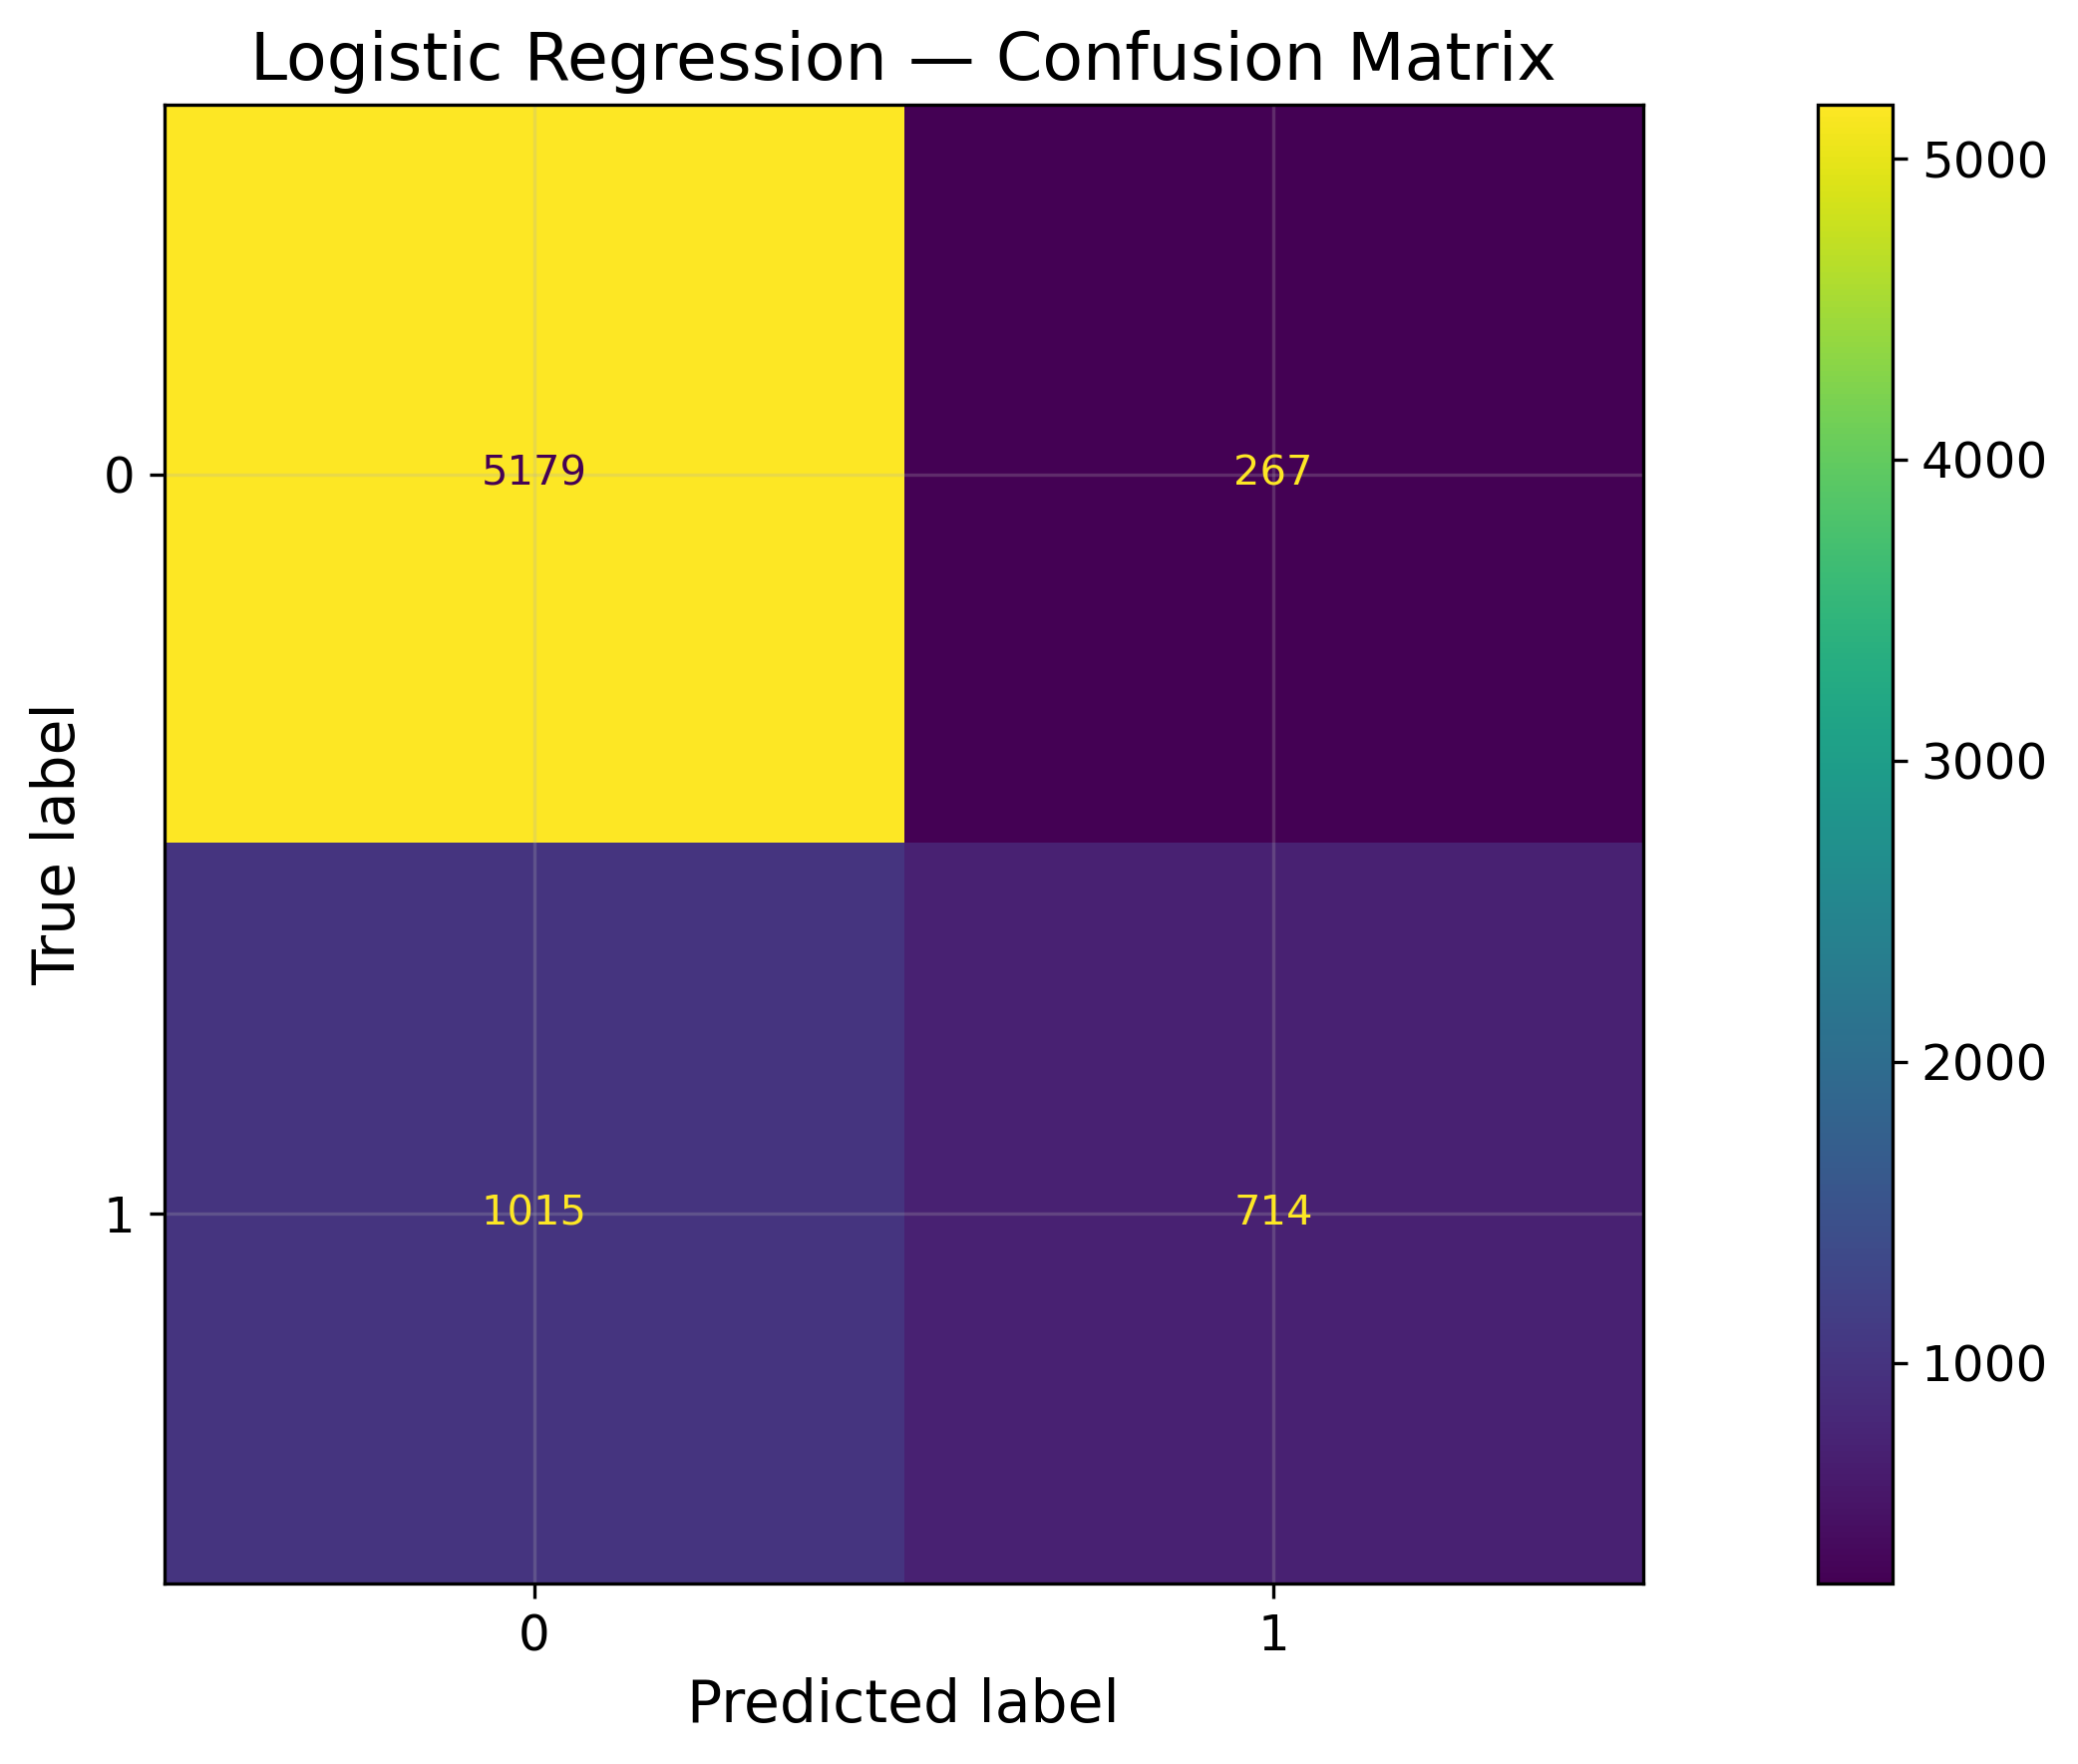

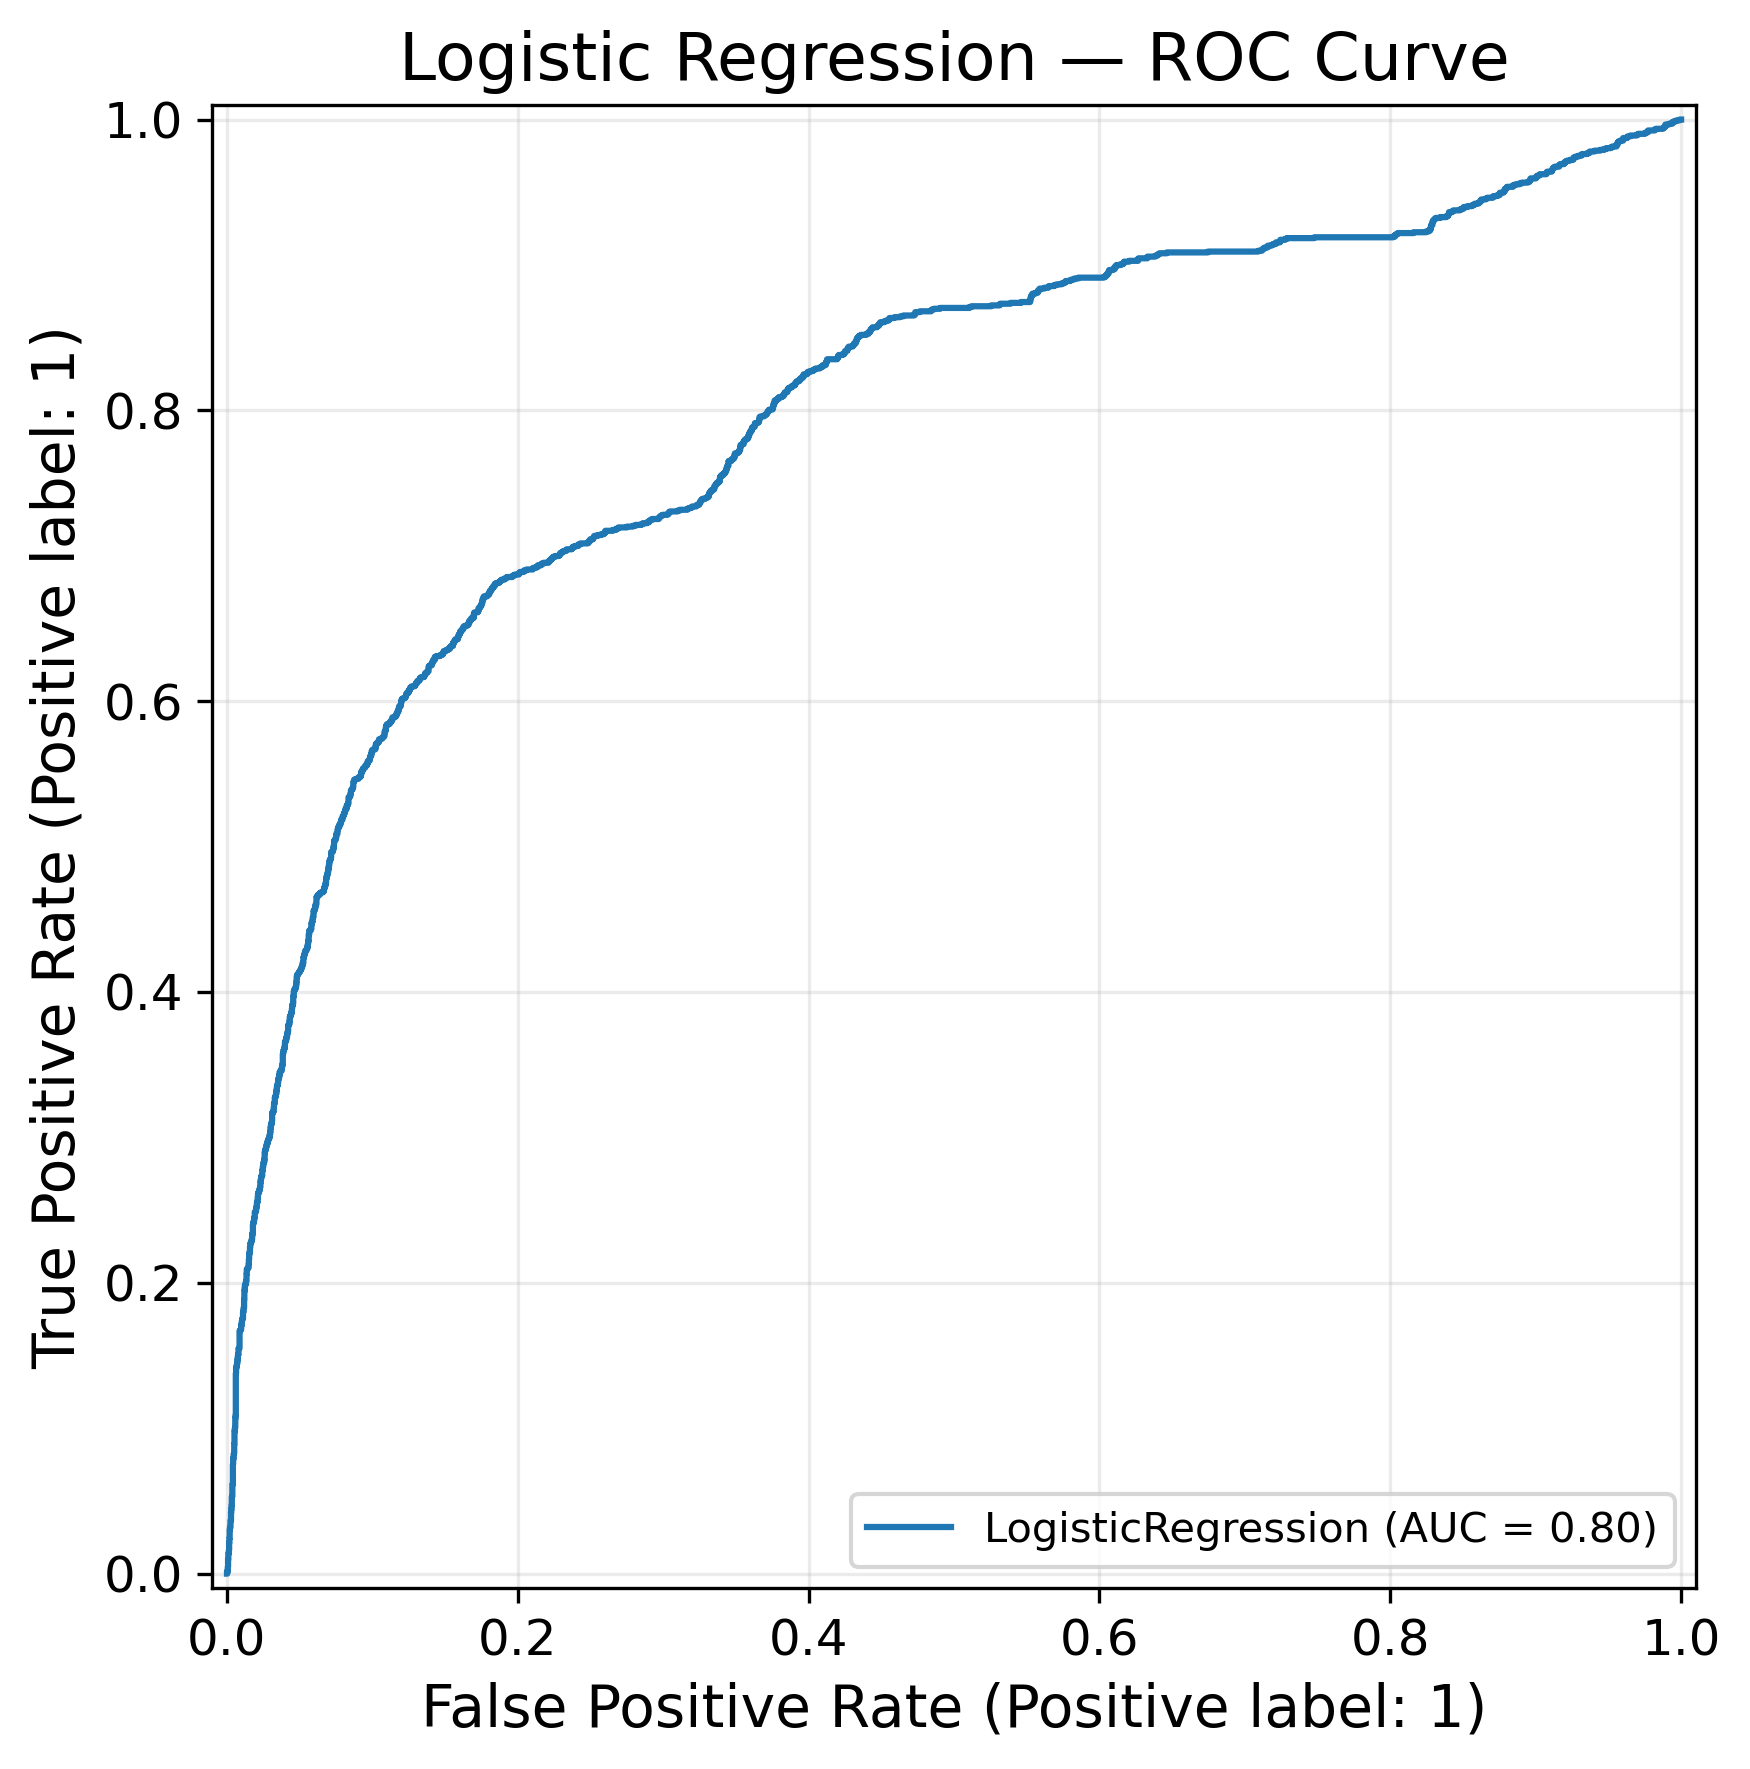

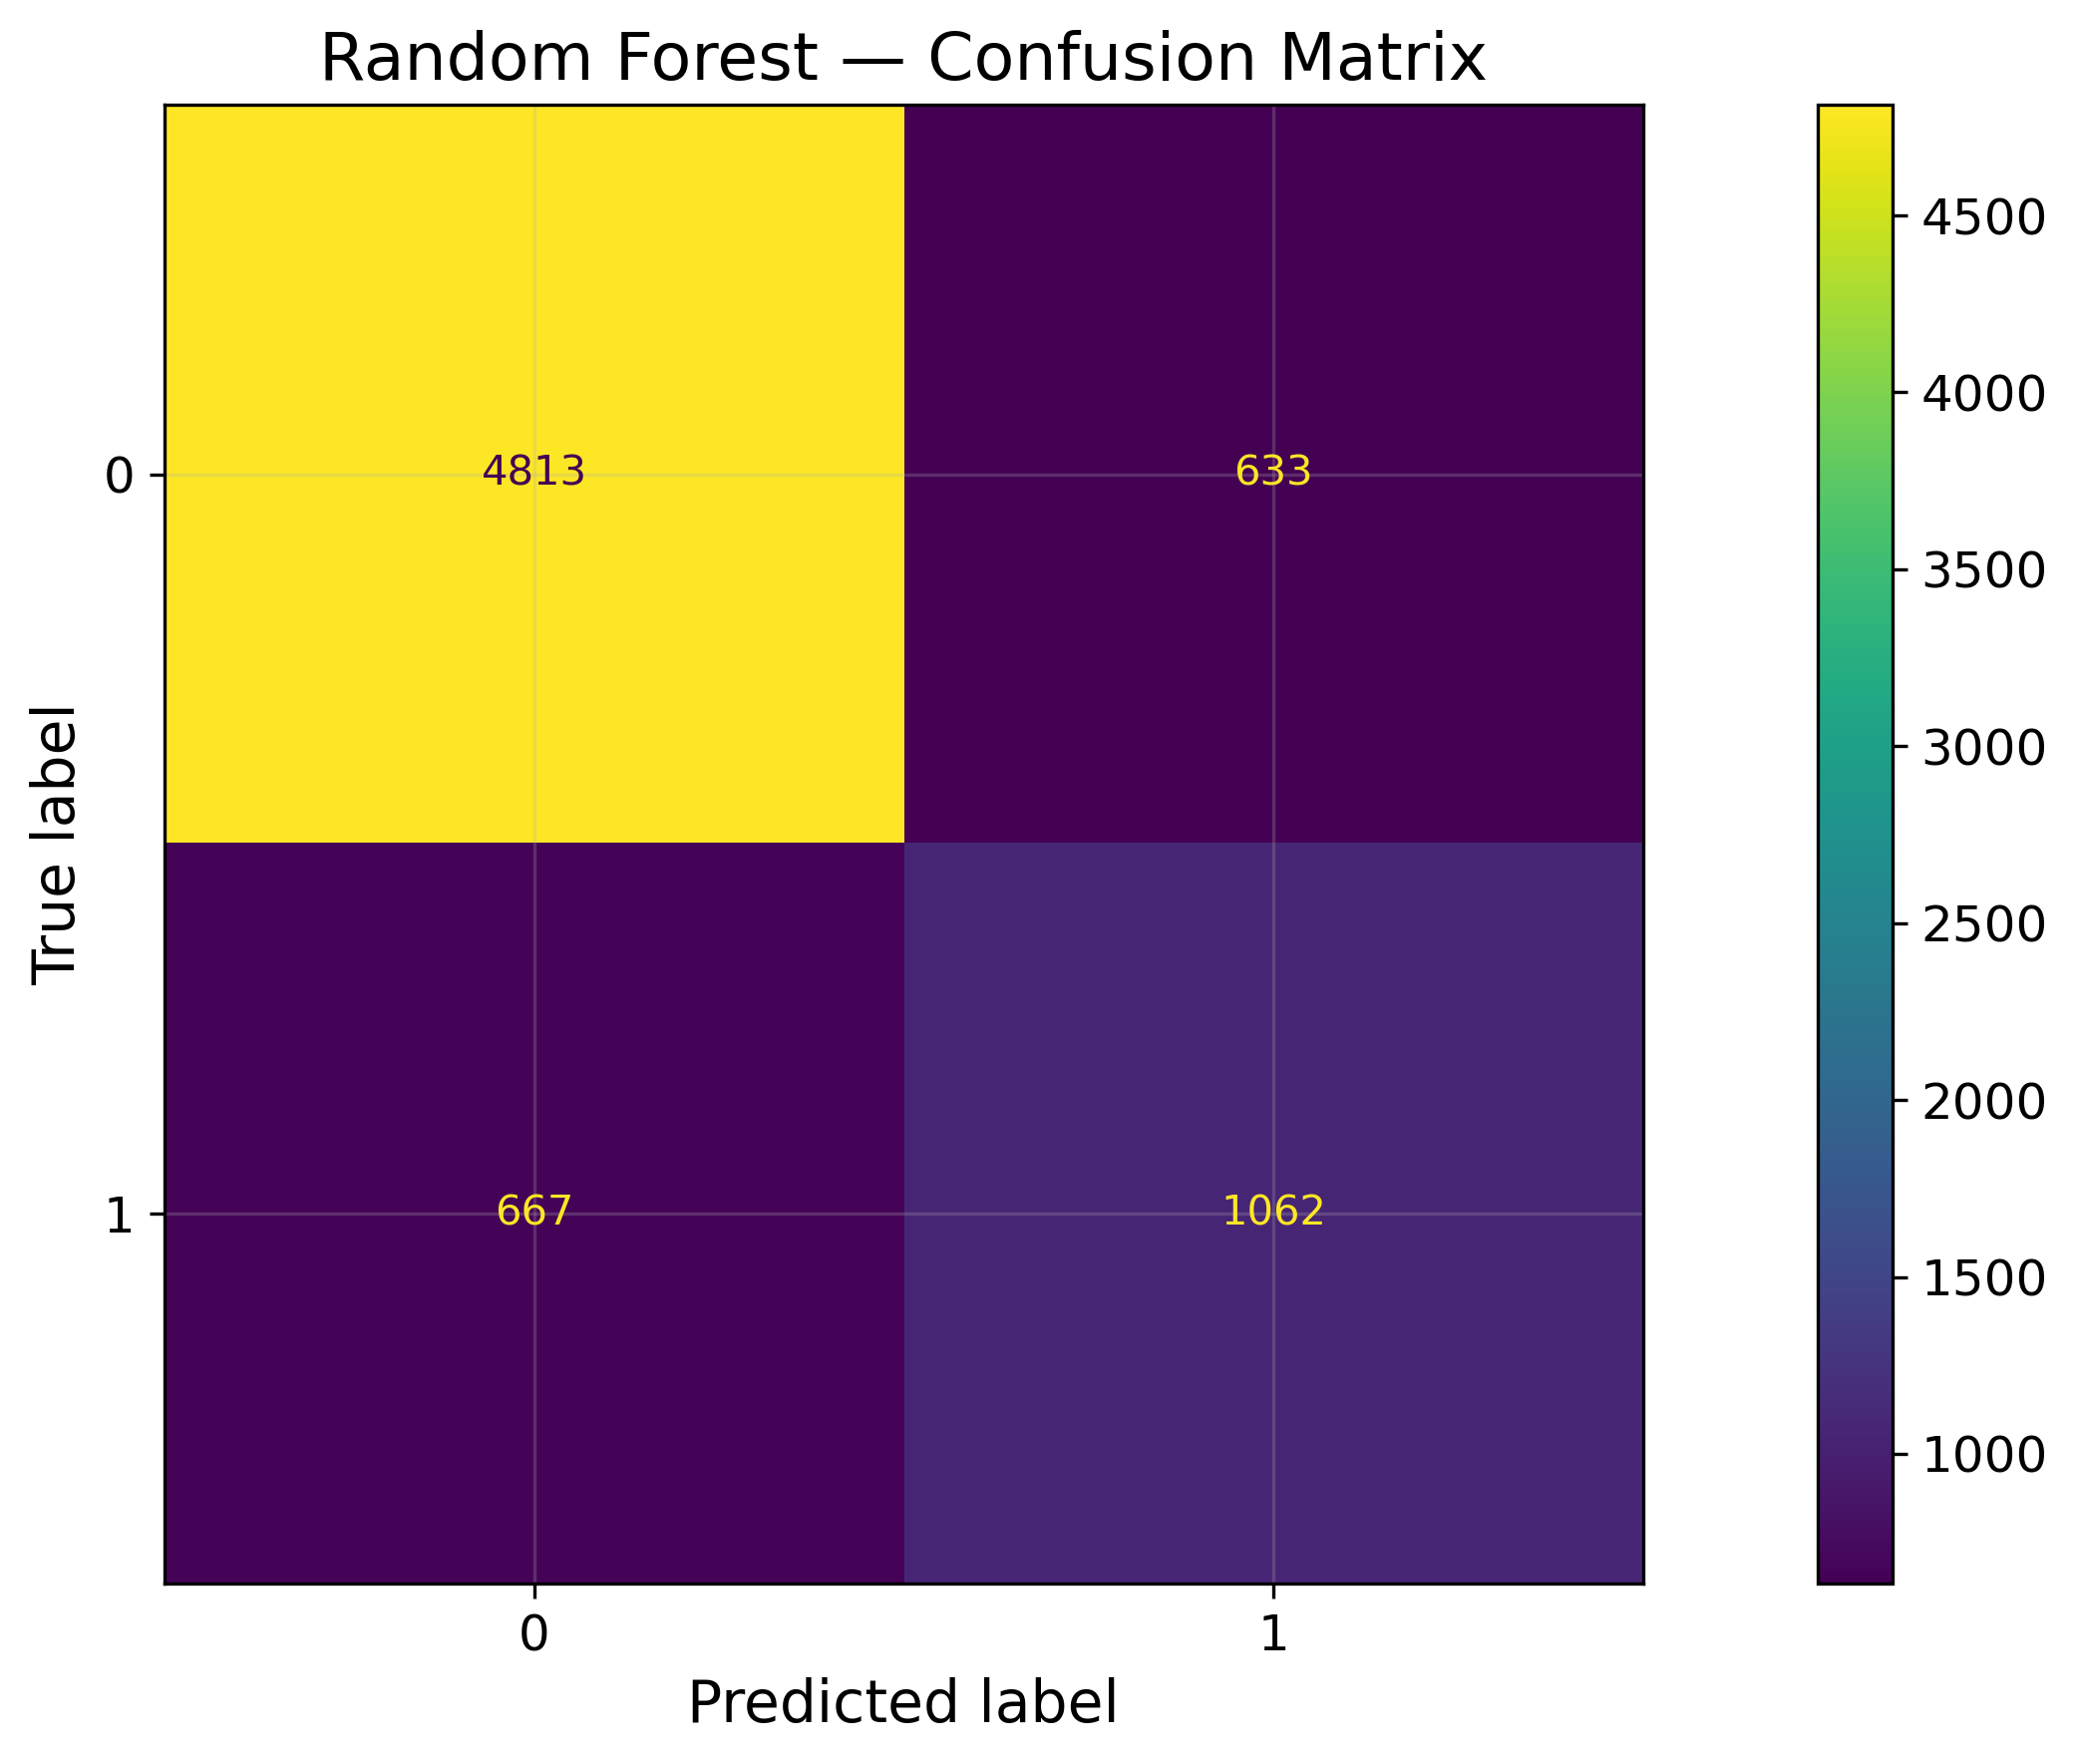

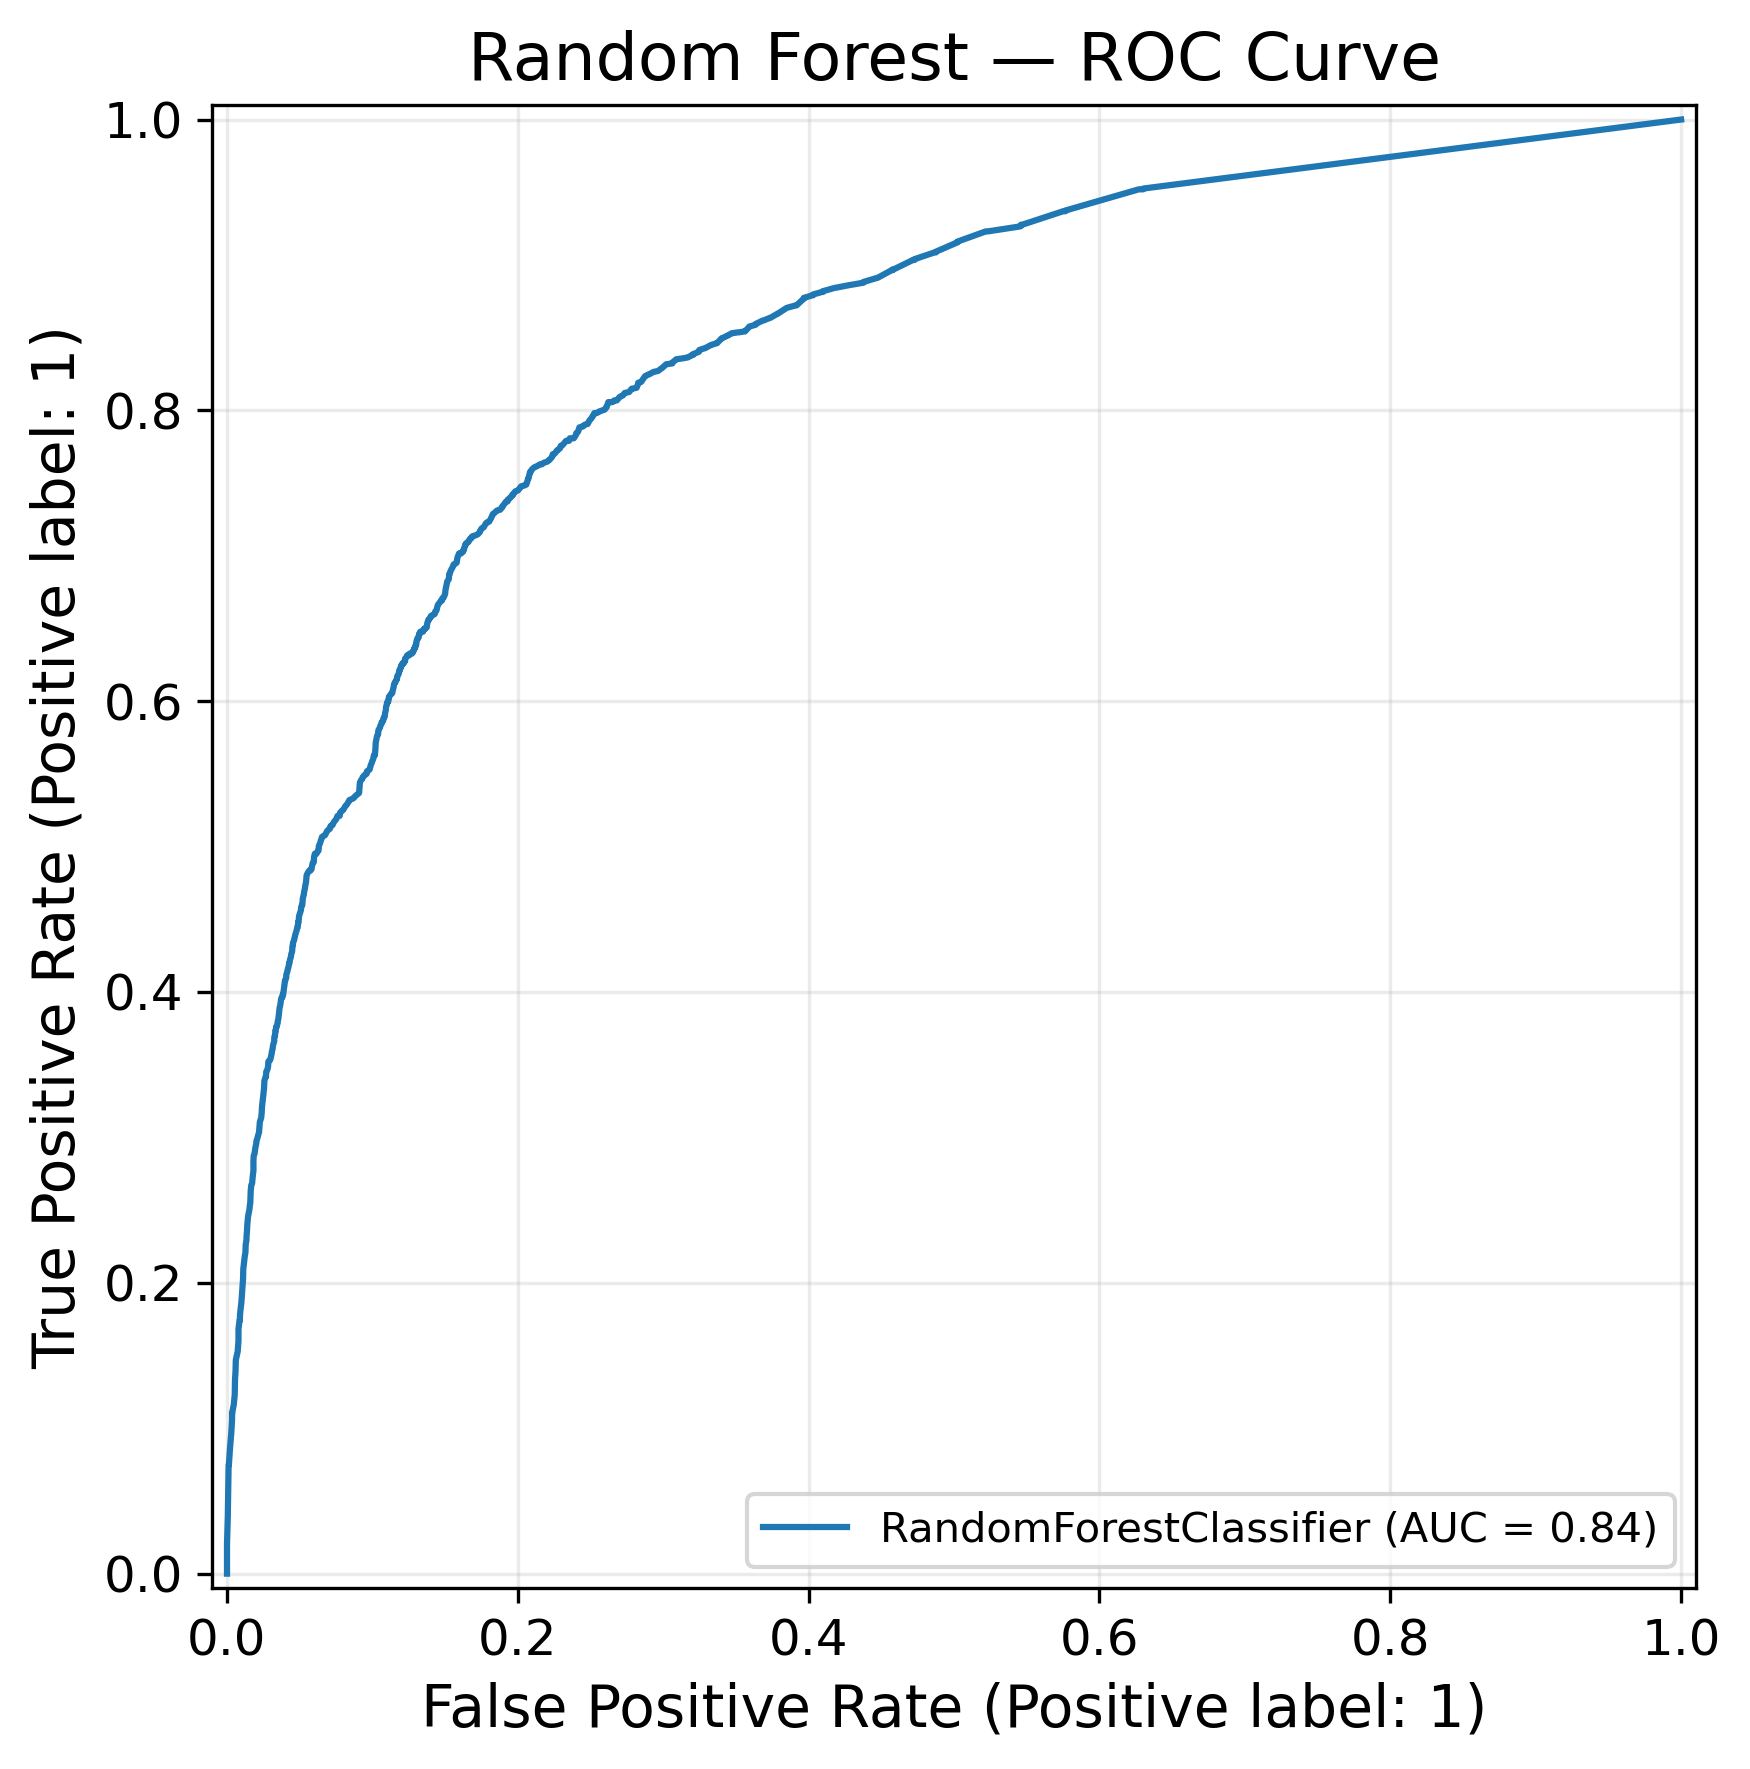

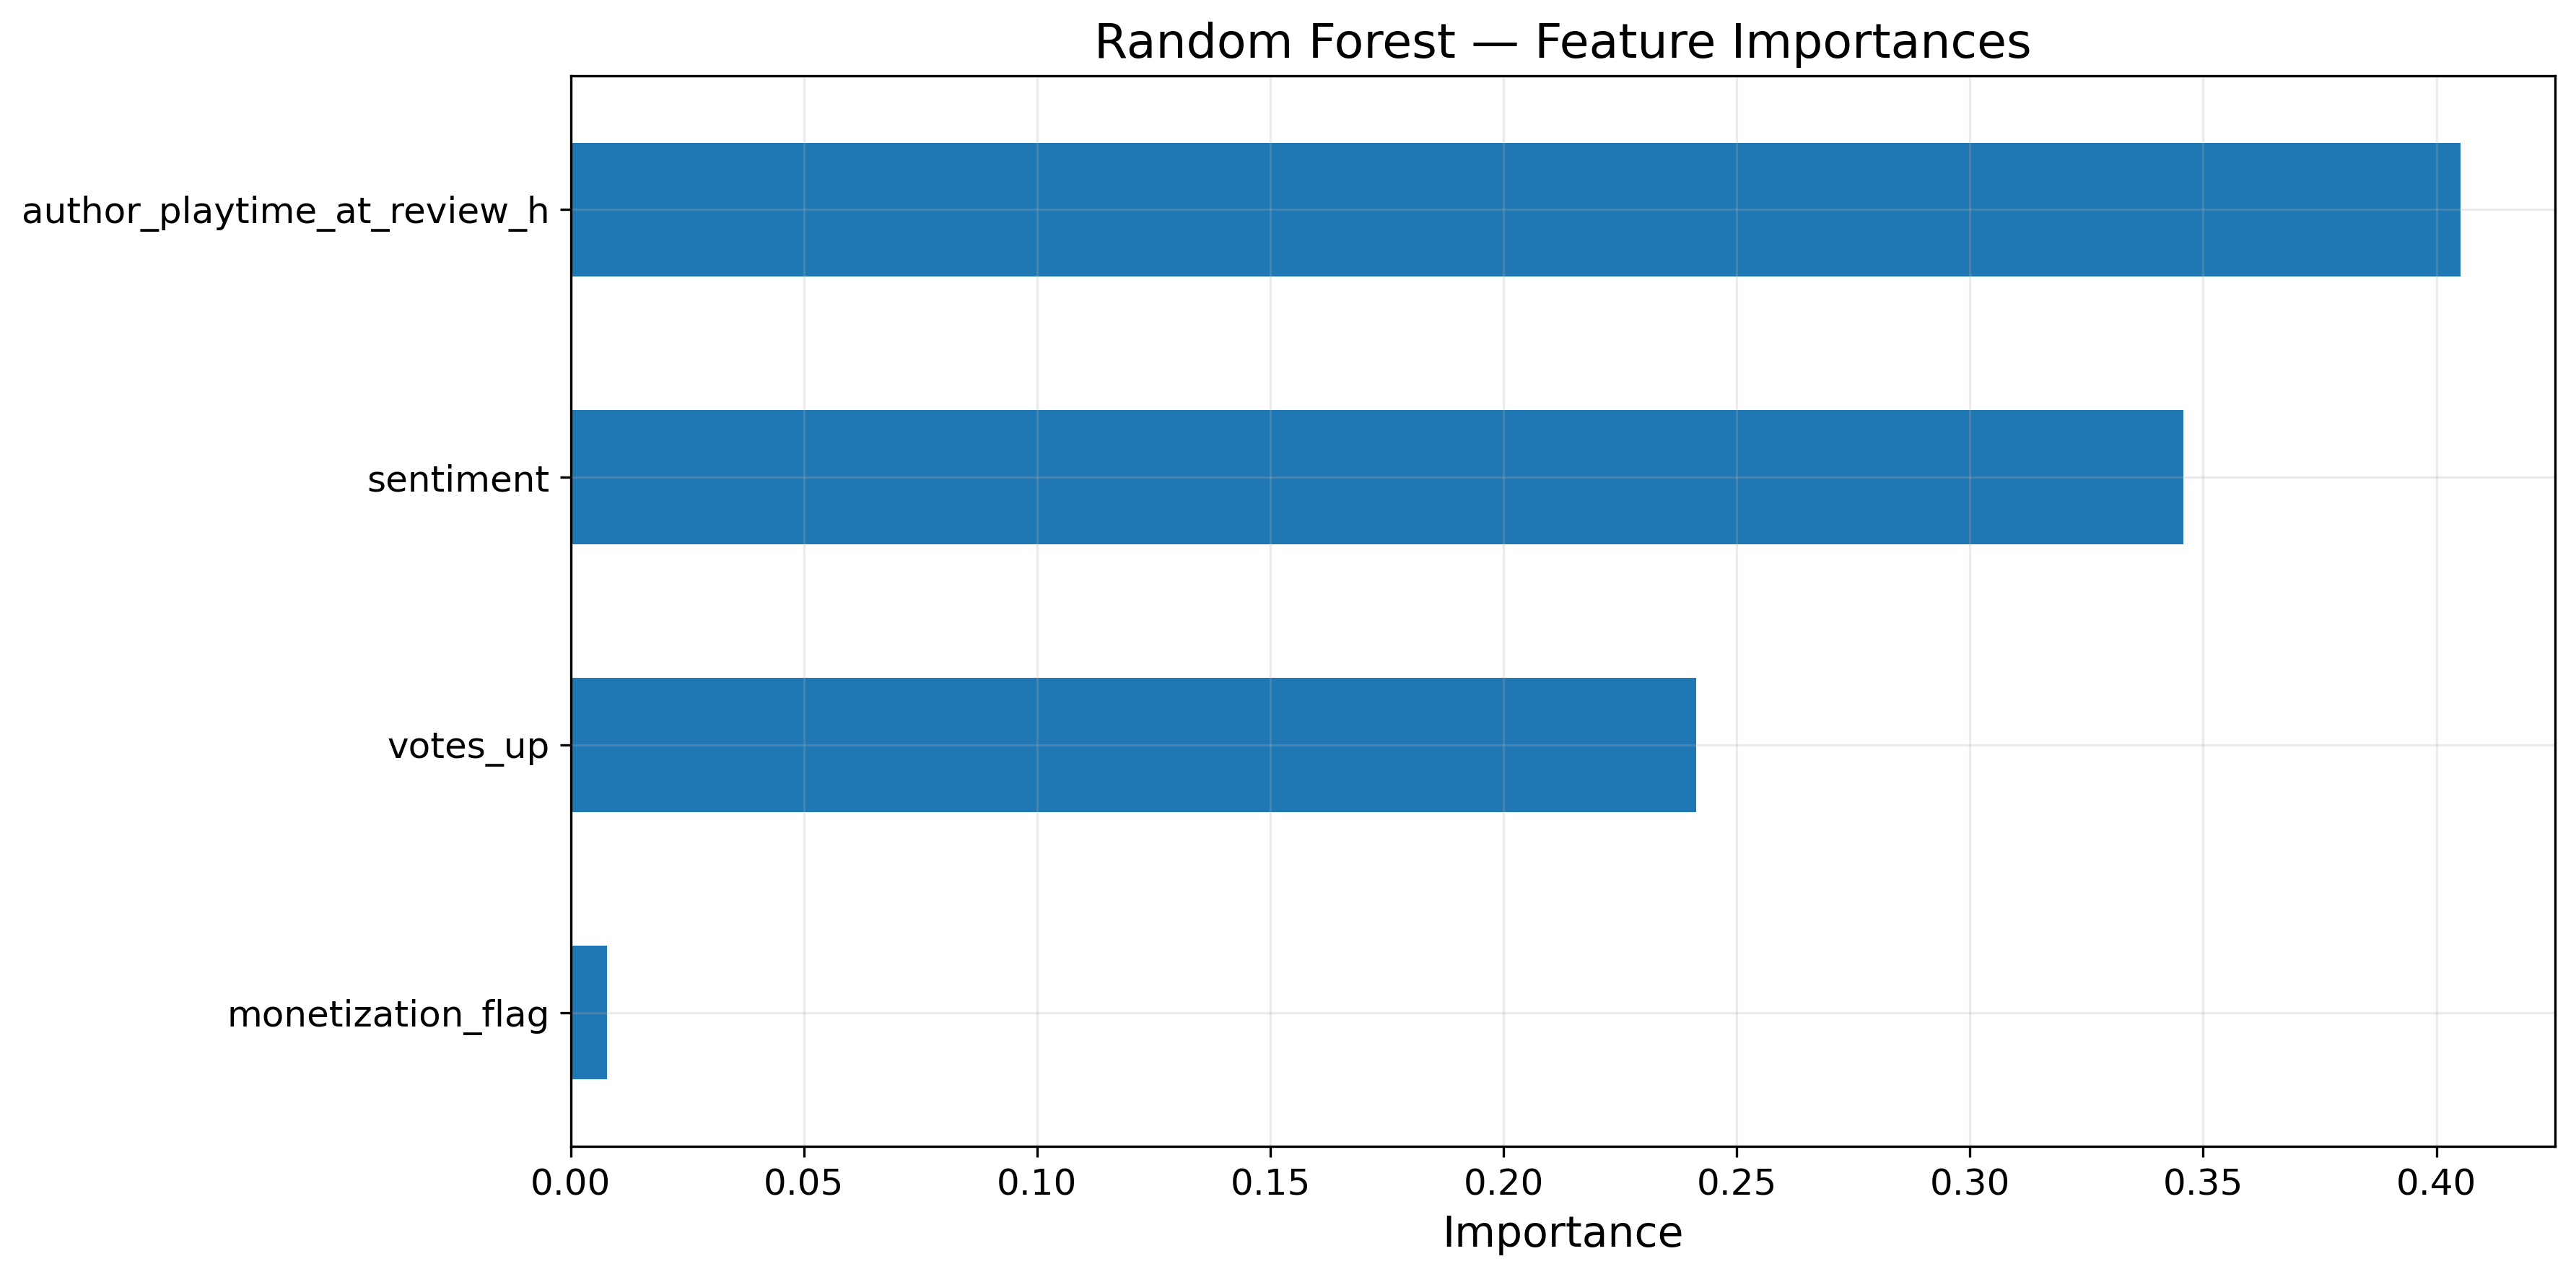

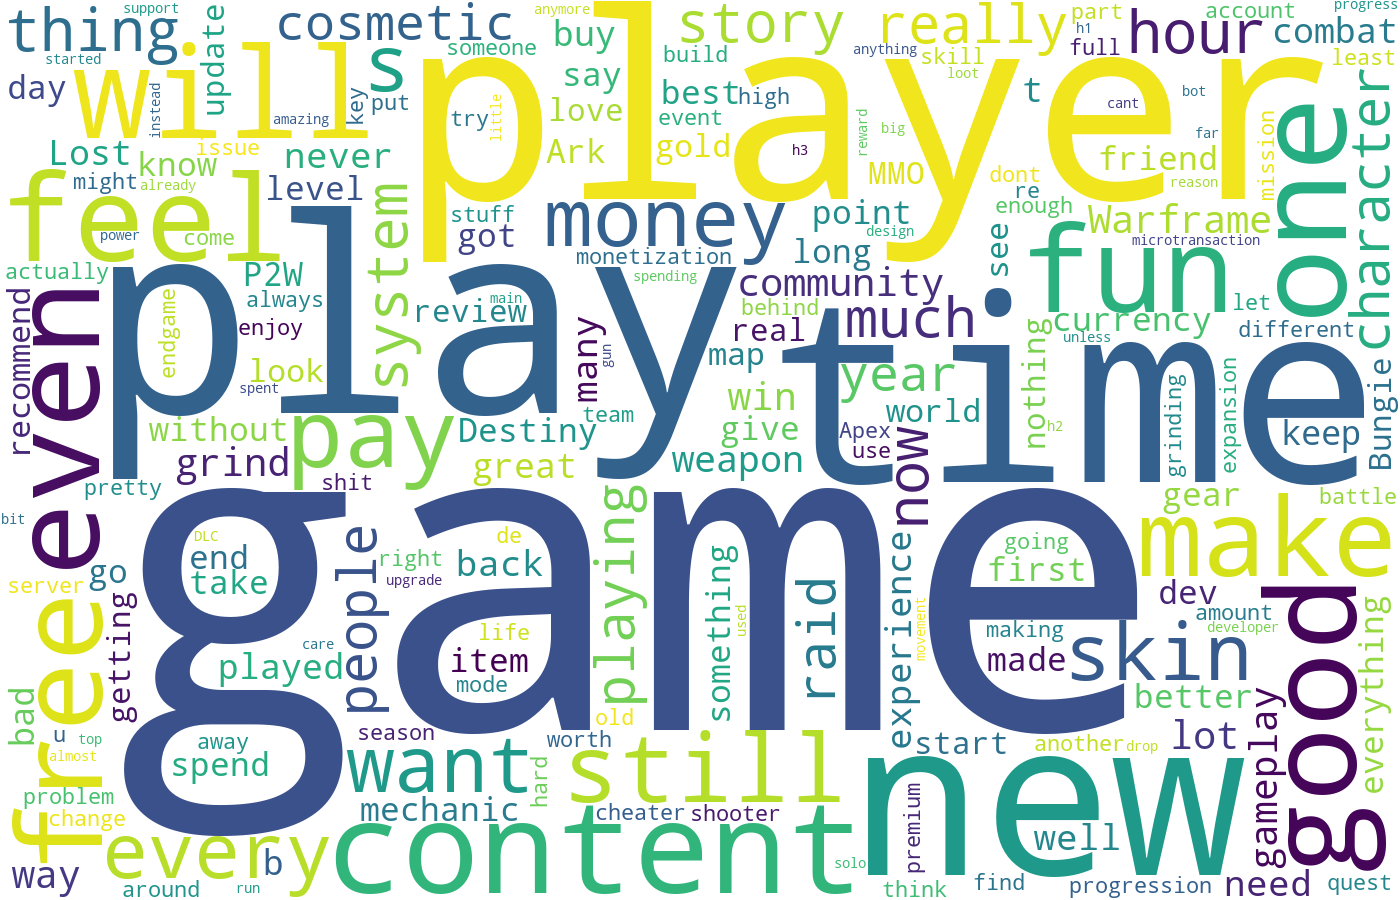

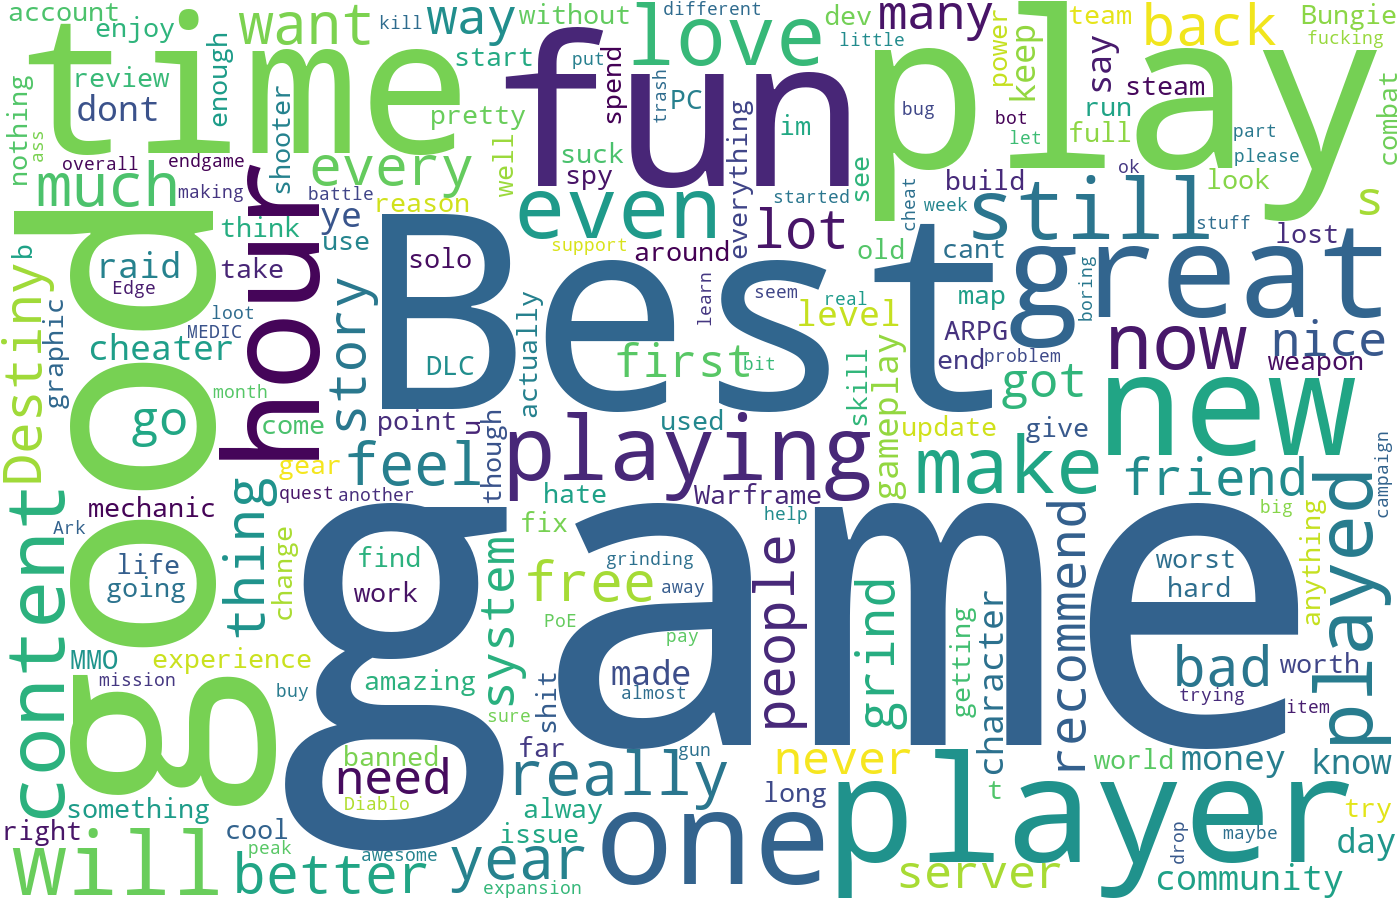

In [7]:
# ======================
# Inline Preview Add-On
# ======================
try:
    from IPython.display import display, Image, HTML
    _IN_NOTEBOOK = True
except Exception:
    _IN_NOTEBOOK = False

def _show_heading(text, level=3):
    if _IN_NOTEBOOK:
        display(HTML(f"<h{level} style='margin:10px 0'>{text}</h{level}>"))
    else:
        print(f"\n{'#'*level} {text}")

def _show_png(path: Path, caption=None, width_px=950):
    if not _IN_NOTEBOOK: return
    if path.exists():
        if caption:
            display(HTML(f"<div style='font-weight:600;margin:6px 0'>{caption}</div>"))
        display(Image(filename=str(path), width=width_px))

def _show_table(csv_path: Path, title=None, n=10):
    if not _IN_NOTEBOOK: return
    if csv_path.exists():
        if title:
            display(HTML(f"<div style='font-weight:600;margin:6px 0'>{title}</div>"))
        try:
            display(pd.read_csv(csv_path).head(n))
        except Exception as e:
            display(HTML(f"<i>Could not display {csv_path.name}: {e}</i>"))

def _show_text(txt_path: Path, title=None, pre=True):
    if txt_path.exists():
        content = txt_path.read_text(encoding="utf-8", errors="ignore")
        if _IN_NOTEBOOK:
            if title: display(HTML(f"<div style='font-weight:600;margin:6px 0'>{title}</div>"))
            block = f"<pre style='background:#fafafa;border:1px solid #eee;padding:10px;'>{content}</pre>" if pre else content
            display(HTML(block))
        else:
            if title: print(f"\n== {title} ==")
            print(content)

# -------- TEXT SUMMARIES --------
_show_heading("TEXT SUMMARIES", level=2)
_show_text(OUT_TXT / "overall_summary.txt", "Overall summary")
_show_text(OUT_TXT / "sentiment_summary.txt", "Sentiment summary")
_show_text(OUT_TXT / "cluster_summary.txt", "Clustering summary (k & silhouette)")
_show_text(OUT_TXT / "clf_lr_report.txt", "Logistic Regression — Classification report")
_show_text(OUT_TXT / "clf_rf_report.txt", "Random Forest — Classification report")
_show_text(OUT_TXT / "rf_cross_validation_summary.txt", "Random Forest 5-fold CV — summary (accuracy / F1 / ROC AUC)")
_show_text(OUT_TXT / "clf_lr_confusion_warning.txt", "LR confusion matrix warning (if any)")
_show_text(OUT_TXT / "clf_lr_roc_warning.txt", "LR ROC warning (if any)")
_show_text(OUT_TXT / "clf_rf_roc_warning.txt", "RF ROC warning (if any)")
_show_text(OUT_TXT / "clf_rf_importance_warning.txt", "RF feature importance warning (if any)")
_show_text(OUT_TXT / "wordcloud_warning.txt", "Word cloud warning (if any)")
_show_text(OUT_TXT / "lda_top_terms.txt", "LDA top terms (JSON extract)")

# -------- TABLE PREVIEWS --------
_show_heading("TABLE PREVIEWS (top rows)", level=2)
_show_table(OUT_TAB / "reviews_per_game.csv", "Review counts per game")
_show_table(OUT_TAB / "monetization_share_by_game.csv", "Share of monetization reviews")
_show_table(OUT_TAB / "playtime_at_review_summary.csv", "Playtime summary (hours at review)")
_show_table(OUT_TAB / "sentiment_summary.csv", "Sentiment distribution summary")
_show_table(OUT_TAB / "avg_sentiment_by_game.csv", "Average sentiment by game")
_show_table(OUT_TAB / "overall_summary.csv", "Overall summary")
_show_table(OUT_TAB / "cluster_profiles.csv", "Cluster profiles (means)")
_show_table(OUT_TAB / "clustering_silhouette_by_k.csv", "Clustering — silhouette score by K")
_show_table(OUT_TAB / "clf_rf_feature_importances.csv", "RF feature importances")
_show_table(OUT_TAB / "rf_cross_validation_scores.csv", "RF cross-validation — per-fold scores")
_show_table(OUT_TAB / "lda_top_terms.csv", "LDA — top terms per topic")

# -------- FIGURES --------
_show_heading("FIGURES", level=2)
# EDA
_show_png(OUT_FIG / "eda_reviews_per_game.png", "Figure: Review count by game")
_show_png(OUT_FIG / "monetization_share_by_game.png", "Figure: Share of reviews mentioning monetization")
_show_png(OUT_FIG / "eda_playtime_hist.png", "Figure: Distribution of playtime at review (hours)")
_show_png(OUT_FIG / "sentiment_hist.png", "Figure: Distribution of review sentiment (VADER compound)")
_show_png(OUT_FIG / "sentiment_avg_by_game.png", "Figure: Average sentiment by game (VADER compound)")

# LDA topics
for i in range(1, 11):
    _show_png(OUT_FIG / f"lda_topic_{i}_top_terms.png", f"Figure: LDA Topic {i} — Top terms")

# Clusters & Prediction
_show_png(OUT_FIG / "clusters_scatter_sentiment_playtime.png", "Figure: K-Means clusters — sentiment vs playtime")
_show_png(OUT_FIG / "clf_lr_confusion_matrix.png", "Logistic Regression — Confusion Matrix")
_show_png(OUT_FIG / "clf_lr_roc.png", "Logistic Regression — ROC Curve")
_show_png(OUT_FIG / "clf_rf_confusion_matrix.png", "Random Forest — Confusion Matrix")
_show_png(OUT_FIG / "clf_rf_roc.png", "Random Forest — ROC Curve")
_show_png(OUT_FIG / "clf_rf_feature_importances.png", "Random Forest — Feature Importances")

# Word clouds
_show_heading("WORD CLOUDS", level=2)
_show_png(OUT_FIG / "monetization_reviews_wordcloud.png", "Figure (Appendix C5): Word Cloud — Monetization-flagged reviews")
_show_png(OUT_FIG / "non_monetization_reviews_wordcloud.png", "Figure (Appendix C6): Word Cloud — Non-monetization reviews")

if not _IN_NOTEBOOK:
    print("\n(Inline preview skipped — not running inside a notebook.)")
else:
    _show_heading("Done. Inline previews rendered.", level=3)
